# Exploratory Data Analysis
This notebook mainly focuses on exploring some properties inside the **whole** datasets (with both dyadic and multiparty conversations) in the specified subreddits.

## Section
- [Processing Dyadic Data](#process-dyadic)
    - [Build a Concise Conversation Dataframe](#process-dyadic-concise)
    - [Tokenize and Lemmatize](#process-dyadic-tokenize)
    - [Total Number of Dialogs](#process-dyadic-dialog)
    - [Total Number of Turns](#process-dyadic-turn)
    - [Turns Distribution in Each Subreddit](#process-dyadic-distribution)
    - [Remove Toxic Text](#process-dyadic-profanity)
    - [Recompute the Descriptive Statistic](#process-dyadic-recompute-stat)
    - [Recompute Totoal Number of Clean and Toxic Conversation Datasets](#process-dyadic-recompute-clean-toxic)
    - [Recompute Total Number of Turns in Clean and Toxic Datasets](#process-dyadic-recompute-turn)
    - [Frequent Words on Both Speaker and Listener on Cleaner Datasets](#process-dyadic-frequent-word)
    - [Language Correct](#process-dyadic-lang-correct)
    - [Sentiment Analysis](#process-dyadic-sentiment)
- [Processing Multiparty Conversations](#process-multi)
    - [Build a Concise Conversation Dataframe](#process-multi-concise)
    - [Tokenize and Lemmatize](#process-multi-tokenize)
    - [Total Number of Dialogs](#process-multi-dialog)
    - [Total Number of Turns](#process-multi-turn)
    - [Turns Distribution in Each Subreddit](#process-multi-distribution)
    - [Remove Toxic Text](#process-multi-profanity)
    - [Recompute Descriptive Statistics](#process-multi-recompute-stat)
    - [Recompute Total Number of Clean and Toxic Dialogs](#process-multi-recompute-clean-toxic)
    - [Recompute Total Number of Turns in Clean and Toxic Dataset](#process-multi-recompute-turn-clean-toxic)
    - [Frequent Words on Both Speaker and Listener on Cleaner Datasets](#process-multi-frequent-word)
    - [Language Correct](#process-multi-lang-correct)
    - [Sentiment Analysis](#process-multi-sentiment)
- [Consider Whole Data](#process-whole)
    - [Total Number of Dyadic and Multiparty Conversations in Each Subreddit](#process-whole-dialog)
    - [Total Number of Dyadic and Multiparty Conversation Turns in Each Subreddit](#process-whole-turn)
    - [Turn Distribution between Dyadic and Multiparty Conversations](#process-whole-distribution)
    - [Emotion Prediction](#process-whole-emotion)

In [ ]:
!pip install contractions
!pip install swifter
!pip install emoji
!pip install profanity-check
!pip install --upgrade language_tool_python
!pip install vaderSentiment

     |████████████████████████████████| 245kB 6.0MB/s 
     |████████████████████████████████| 317kB 15.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81694 sha256=2aa84ec37d1a37987bd4f5b26b5c77e414da1b957688f04cff7537e078232a8a
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 634kB 4.2MB/s 
     |████████████████████████████████| 296kB 15.8MB/s 
     |████████████████████████████████| 542kB 18.2MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 17.2MB 235kB/s 
     |████████████████████████████████| 48.5MB 92kB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 133kB 41.8MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
     |███████████████

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocess as mp
import re
import nltk
import contractions
import swifter
import string
import language_tool_python
from emoji import UNICODE_EMOJI
from collections import Counter
from itertools import islice, repeat
from nltk import pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import words, stopwords, wordnet
from joblib import Parallel, delayed
from profanity_check import predict_prob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from utils4text import *

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')

tool = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


<a name="process-dyadic"></a>
## Processing **Dyadic** Conversations
In this part, process the data merely on those with dyadic conversations. Note that these dyadic conversations are only the conversations between post authors and first comment authors.

In [ ]:
# load dyadic dataframes combined posts and comments
sad_dyadic_convs = pd.read_csv('sad_dyadic_convs.csv').drop_duplicates().drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).dropna(subset= ['post_content', 'comment_content'])
depressed_dyadic_convs = pd.read_csv('depressed_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
depression_dyadic_convs = pd.read_csv('depression_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
offmychest_dyadic_convs = pd.read_csv('offmychest_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
suicidewatch_dyadic_convs = pd.read_csv('suicidewatch_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
depression_help_dyadic_convs = pd.read_csv('depression_help_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
anxietyhelp_dyadic_convs = pd.read_csv('Anxietyhelp_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
mentalhealthsupport_dyadic_convs = pd.read_csv('MentalHealthSupport_dyadic_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])

<a name="process-dyadic-concise"></a>
### Build a Concise Conversation Dataframe
In this part, the original dataframe will be reconstructed to make a more concise version of conversation dataframe. And this dataframe will then be used to analyze the tokens. The concise dataframe contains the attributes: conversation ID, subreddit, post title, author, dialog turn, and text. 

#### Asynchronous way using `multiprocess` to build conversation sets
It turns out that this method executes the large dataframes very slowly. Small ones are fine.

In [ ]:
# set up multiprocessing unit
pool = mp.Pool(mp.cpu_count())

# build more concise conversation dataframes specified by Supervisor (asynchronous --> slow on large dataframes)
depression_dyadic_convs_concise = (pool.apply_async(build_convs, [depression_dyadic_convs])).get()
depressed_dyadic_convs_concise = (pool.apply_async(build_convs, [depressed_dyadic_convs])).get()
offmychest_dyadic_convs_concise = (pool.apply_async(build_convs, [offmychest_dyadic_convs])).get()
suicidewatch_dyadic_convs_concise = (pool.apply_async(build_convs2, [suicidewatch_dyadic_convs])).get()
sad_dyadic_convs_concise = (pool.apply_async(build_convs, [sad_dyadic_convs])).get()
depression_help_dyadic_convs_concise = (pool.apply_async(build_convs, [depression_help_dyadic_convs])).get()
anxietyhelp_dyadic_convs_concise = (pool.apply_async(build_convs, [anxietyhelp_dyadic_convs])).get()
mentalhealthsupport_dyadic_convs_concise = (pool.apply_async(build_convs, [mentalhealthsupport_dyadic_convs])).get()

In [ ]:
depressed_dyadic_convs_concise = depressed_dyadic_convs_concise.reset_index().drop('index', axis = 1)
sad_dyadic_convs_concise = sad_dyadic_convs_concise.reset_index().drop('index', axis = 1)
suicidewatch_dyadic_convs_concise = suicidewatch_dyadic_convs_concise.reset_index().drop('index', axis = 1)
depression_help_dyadic_convs_concise = depression_help_dyadic_convs_concise.reset_index().drop('index', axis = 1)
anxietyhelp_dyadic_convs_concise = anxietyhelp_dyadic_convs_concise.reset_index().drop('index', axis = 1)
mentalhealthsupport_dyadic_convs_concise = mentalhealthsupport_dyadic_convs_concise.reset_index().drop('index', axis = 1)

#### Parallel way using `Parallel` to build conversation sets
This is much better and faster in processing the large dataframes. **Recommended!**

In [ ]:
# build more concise conversation dataframes specified by Supervisor (parallel -- > much faster)
depression_dyadic_convs_concise = build_concise_convs_df(depression_dyadic_convs)
depressed_dyadic_convs_concise = build_concise_convs_df(depressed_dyadic_convs)
offmychest_dyadic_convs_concise = build_concise_convs_df(offmychest_dyadic_convs)
suicidewatch_dyadic_convs_concise = build_concise_convs_df(suicidewatch_dyadic_convs)
sad_dyadic_convs_concise = build_concise_convs_df(sad_dyadic_convs)
depression_help_dyadic_convs_concise = build_concise_convs_df(depression_help_dyadic_convs)
anxietyhelp_dyadic_convs_concise = build_concise_convs_df(anxietyhelp_dyadic_convs)
mentalhealthsupport_dyadic_convs_concise = build_concise_convs_df(mentalhealthsupport_dyadic_convs)

In [ ]:
# save dataframe
depression_dyadic_convs_concise.to_csv('depression_dyadic_convs_concise.csv')

<a name="process-dyadic-tokenize"></a>
### Tokenize and Lemmatize
In this part, the raw texts from posts and comments would be processed to keep only the meaningful words. That is, unnecessary marks and stopwords will be removed. 

In [ ]:
# load conversation sets (depression subreddit for example)
subreddit_dyadic_convs_concise = pd.read_csv('depression_dyadic_convs_concise.csv', index_col=[0])
subreddit_dyadic_convs_concise

In [ ]:
subreddit_dyadic_tokens = compute_tokens(subreddit_dyadic_convs_concise)
subreddit_dyadic_tokens

0          [This, bit, ramble, ,, warn, ., When, I, go, a...
1          [Hey, seem, like, really, sweet, nice, person,...
2          [Yesterday, told, best, friend, (, girl, ), I,...
3          [I, mean, bad, way, lot, fish, sea, ., Have, e...
4          [I, even, know, I, ., I, particularly, rough, ...
                                 ...                        
1434043    [NONWORD, Disorder, (, manic, depression, ), m...
1434044    [Hi, ., I, senior, high, school, ,, I, struggl...
1434045    [Thank, share, ., How, approach, John, somethi...
1434046    [Aside, work, ,, get, bed, ., I, try, ,, time,...
1434047    [I, know, feel, ., One, big, issue, depression...
Name: text, Length: 1434048, dtype: object

In [ ]:
# calculate total number of tokens in the given subreddit
sum(subreddit_dyadic_tokens.apply(len))

109598455

<a name="process-dyadic-dialog"></a>
### Total Number of Dialogs
For each subreddit, compute the total number of dyadic dialogs and compare it via visualizing a bar chart.

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_diags = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                          'length': [len(depression_dyadic_convs.link_id.unique()), 
                                     len(depressed_dyadic_convs.link_id.unique()), 
                                     len(offmychest_dyadic_convs.link_id.unique()), 
                                     len(sad_dyadic_convs.link_id.unique()), 
                                     len(suicidewatch_dyadic_convs.link_id.unique()), 
                                     len(depression_help_dyadic_convs.link_id.unique()), 
                                     len(anxietyhelp_dyadic_convs.link_id.unique()), 
                                     len(mentalhealthsupport_dyadic_convs.link_id.unique())]
})

subreddits_dyadic_diags

,subreddit,length
0,depression,584999
1,depressed,10892
2,offmychest,467457
3,sad,18827
4,suicidewatch,317717
5,depression_help,23678
6,Anxietyhelp,8297
7,MentalHealthSupport,3551


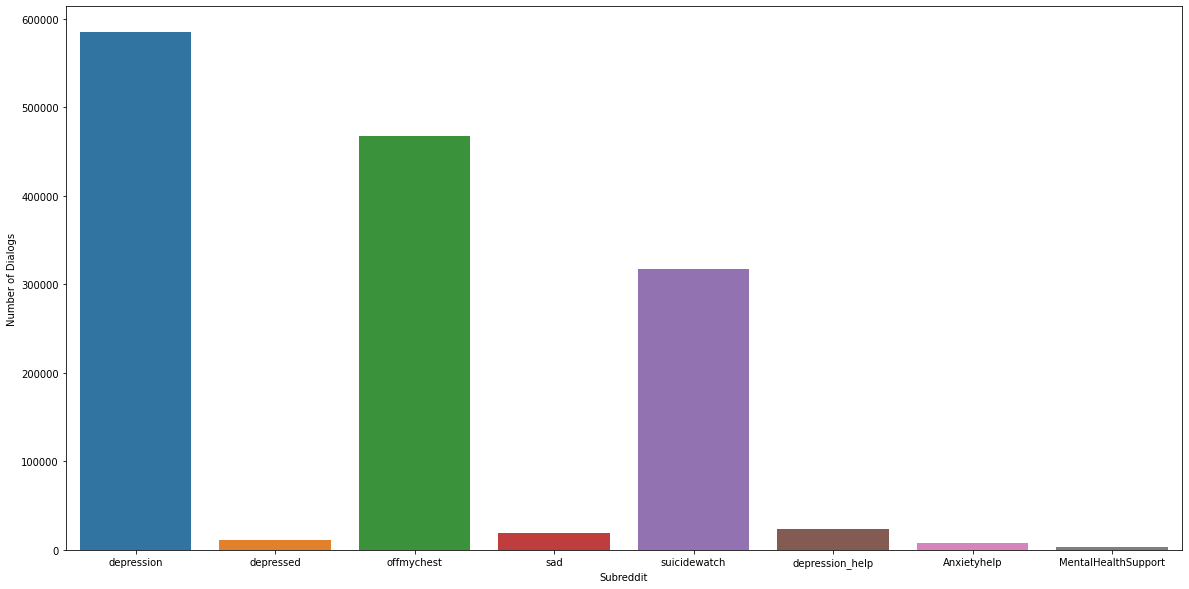

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_diags)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

<a name="process-dyadic-turn"></a>
### Total Number of Turns
For each subreddit, compute the total number of turns and compare it via visualizing a bar chart. Note that each post or comment can be counted as a turn.

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_turns = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                          'length': [len(depression_dyadic_convs) + len(depression_dyadic_convs.link_id.unique()), 
                                     len(depressed_dyadic_convs) + len(depressed_dyadic_convs.link_id.unique()), 
                                     len(offmychest_dyadic_convs) + len(offmychest_dyadic_convs.link_id.unique()), 
                                     len(sad_dyadic_convs) + len(sad_dyadic_convs.link_id.unique()), 
                                     len(suicidewatch_dyadic_convs) + len(suicidewatch_dyadic_convs.link_id.unique()), 
                                     len(depression_help_dyadic_convs) + len(depression_help_dyadic_convs.link_id.unique()), 
                                     len(anxietyhelp_dyadic_convs) + len(anxietyhelp_dyadic_convs.link_id.unique()), 
                                     len(mentalhealthsupport_dyadic_convs) + len(mentalhealthsupport_dyadic_convs.link_id.unique())]
})

subreddits_dyadic_turns

,subreddit,length
0,depression,1434048
1,depressed,24230
2,offmychest,1085104
3,sad,43010
4,suicidewatch,823556
5,depression_help,52348
6,Anxietyhelp,18449
7,MentalHealthSupport,7972


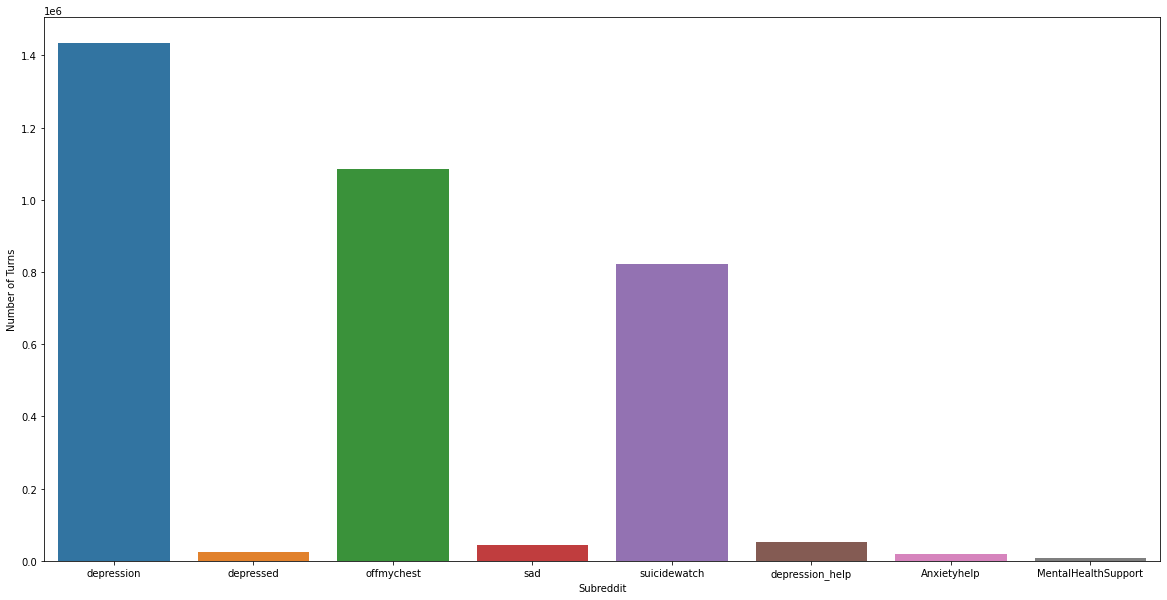

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_turns)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

<a name="process-dyadic-distribution"></a>
### Turns Distribution in Each Subreddit
The number of turns inside the conversations in a given subreddit varies. Here we visualize the distribution using a histogram to show how conversation turns distribute.

In [ ]:
# load conversation data
sad_dyadic_convs_concise = pd.read_csv('conversations/sad_dyadic_convs_concise.csv', index_col=[0])
depression_dyadic_convs_concise = pd.read_csv('conversations/depression_dyadic_convs_concise.csv', index_col=[0])
depressed_dyadic_convs_concise = pd.read_csv('conversations/depressed_dyadic_convs_concise.csv', index_col=[0])
offmychest_dyadic_convs_concise = pd.read_csv('conversations/offmychest_dyadic_convs_concise.csv', index_col=[0])
suicidewatch_dyadic_convs_concise = pd.read_csv('conversations/suicidewatch_dyadic_convs_concise.csv', index_col=[0])
depression_help_dyadic_convs_concise = pd.read_csv('conversations/depression_help_dyadic_convs_concise.csv', index_col=[0])
anxietyhelp_dyadic_convs_concise = pd.read_csv('conversations/anxietyhelp_dyadic_convs_concise.csv', index_col=[0])
mentalhealthsupport_dyadic_convs_concise = pd.read_csv('conversations/mentalhealthsupport_dyadic_convs_concise.csv', index_col=[0])

In [ ]:
# calculate dialog turn distribution
sad_dyadic_convs_turn_dist = compute_turn_distribution(sad_dyadic_convs_concise)
depression_dyadic_convs_turn_dist = compute_turn_distribution(depression_dyadic_convs_concise)
depressed_dyadic_convs_turn_dist = compute_turn_distribution(depressed_dyadic_convs_concise)
offmychest_dyadic_convs_turn_dist = compute_turn_distribution(offmychest_dyadic_convs_concise)
suicidewatch_dyadic_convs_turn_dist = compute_turn_distribution(suicidewatch_dyadic_convs_concise)
depression_help_dyadic_convs_turn_dist = compute_turn_distribution(depression_help_dyadic_convs_concise)
anxietyhelp_dyadic_convs_turn_dist = compute_turn_distribution(anxietyhelp_dyadic_convs_concise)
mentalhealthsupport_dyadic_convs_turn_dist = compute_turn_distribution(mentalhealthsupport_dyadic_convs_concise)

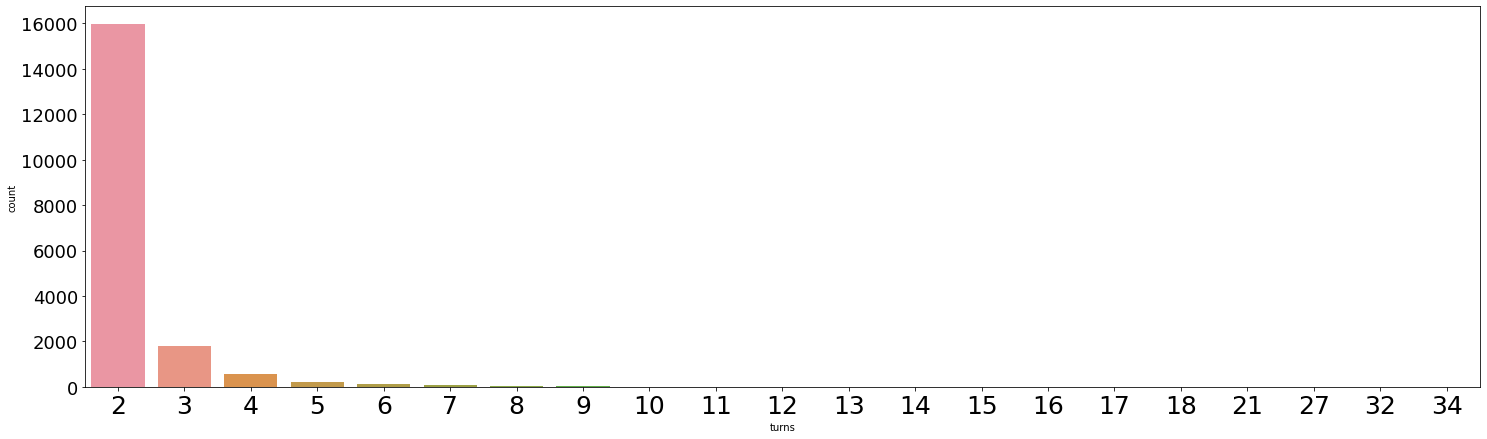

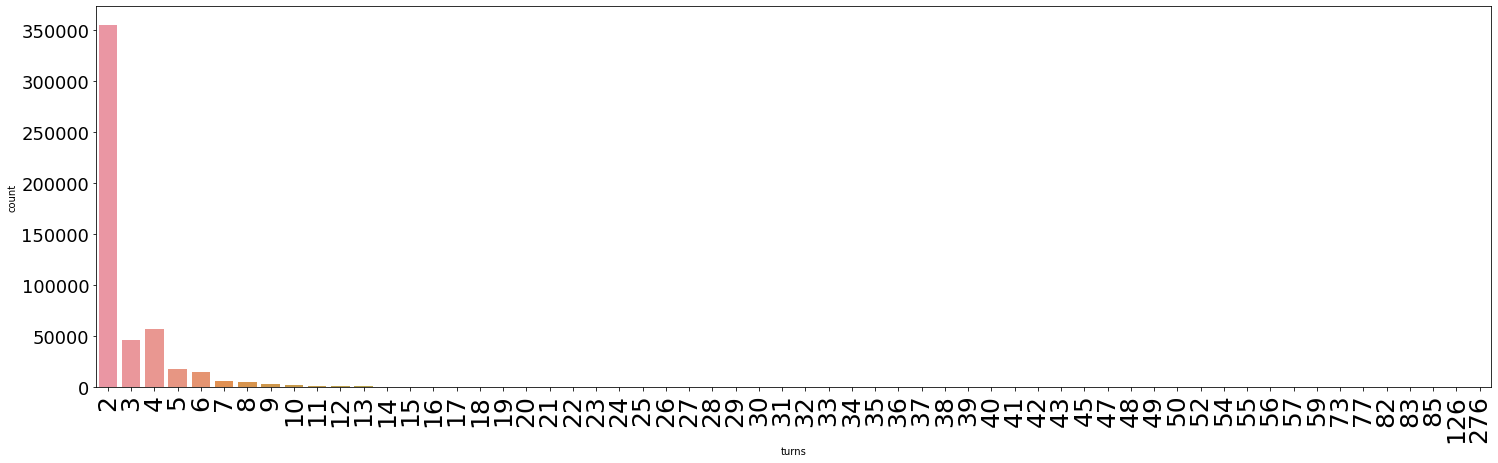

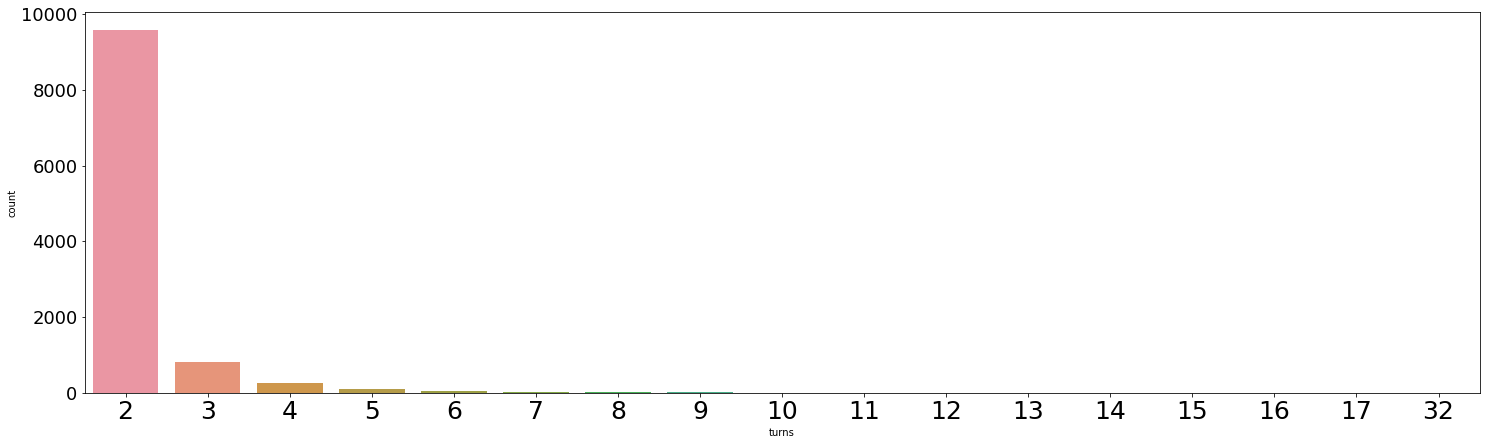

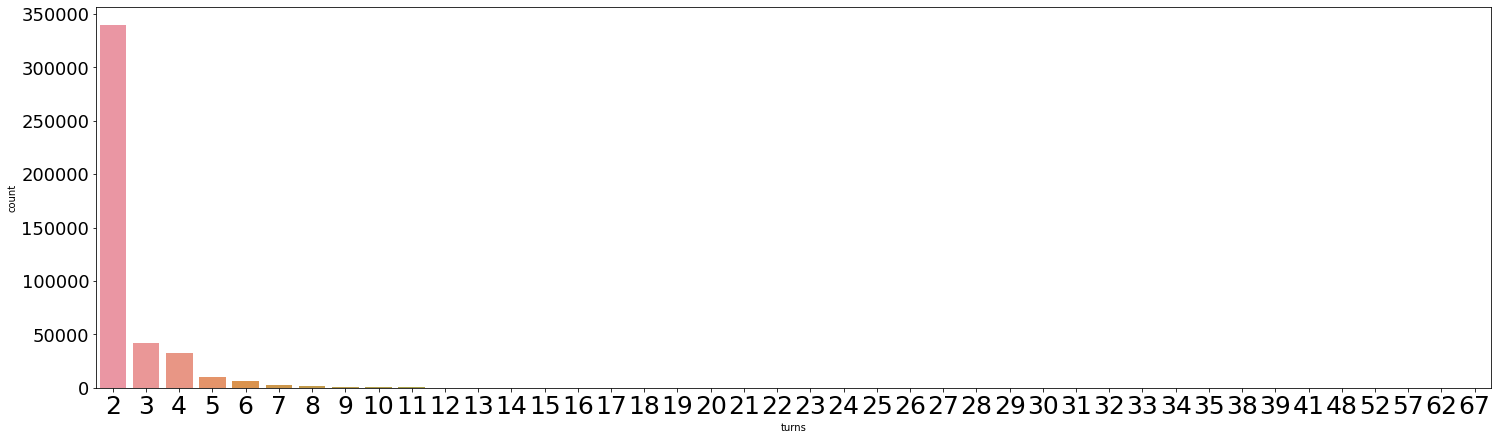

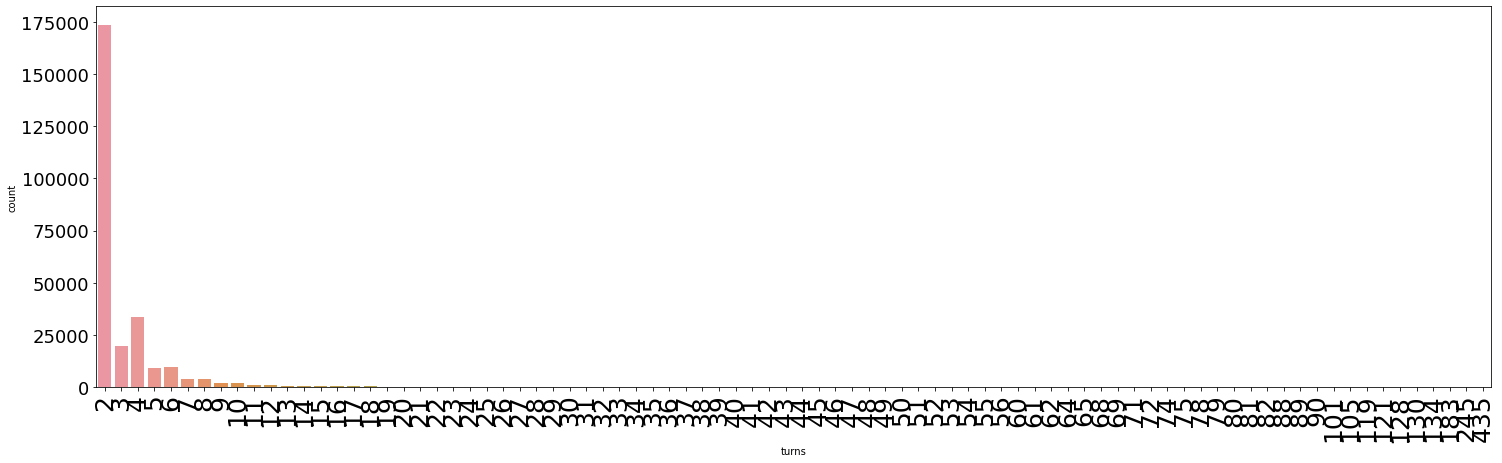

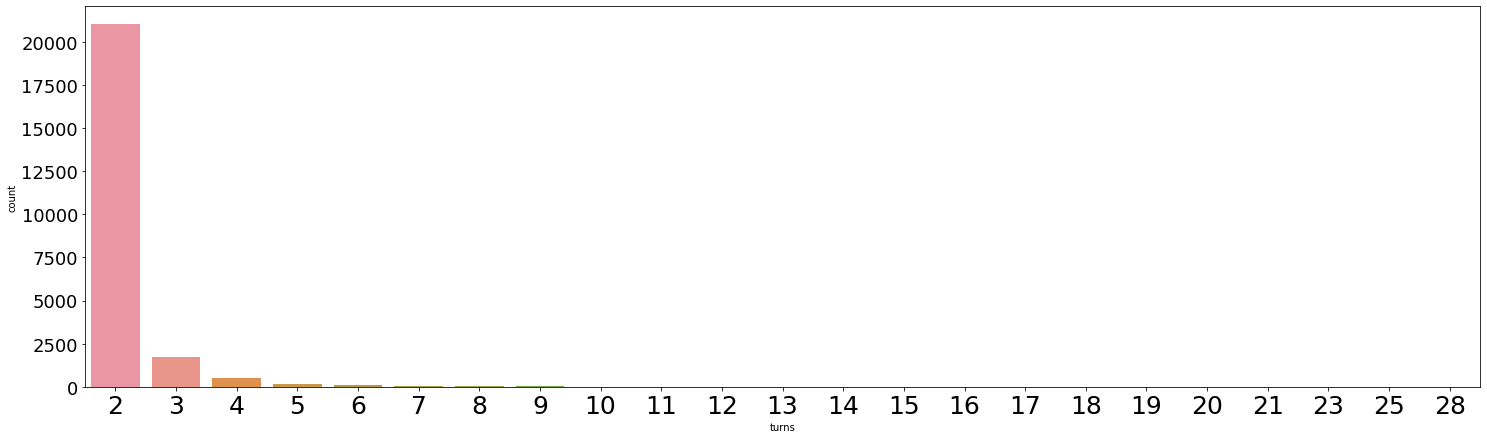

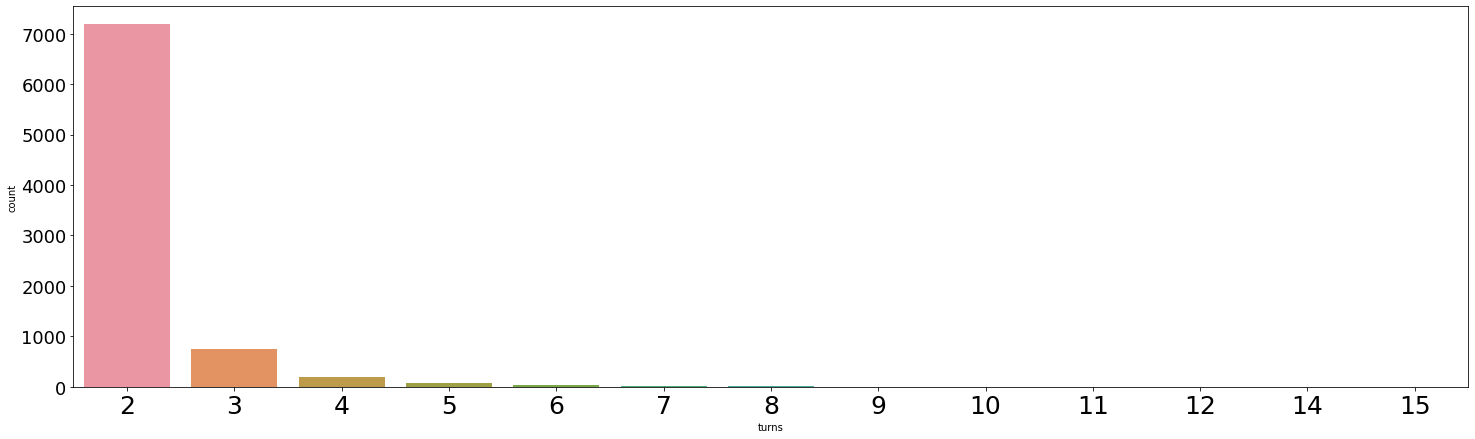

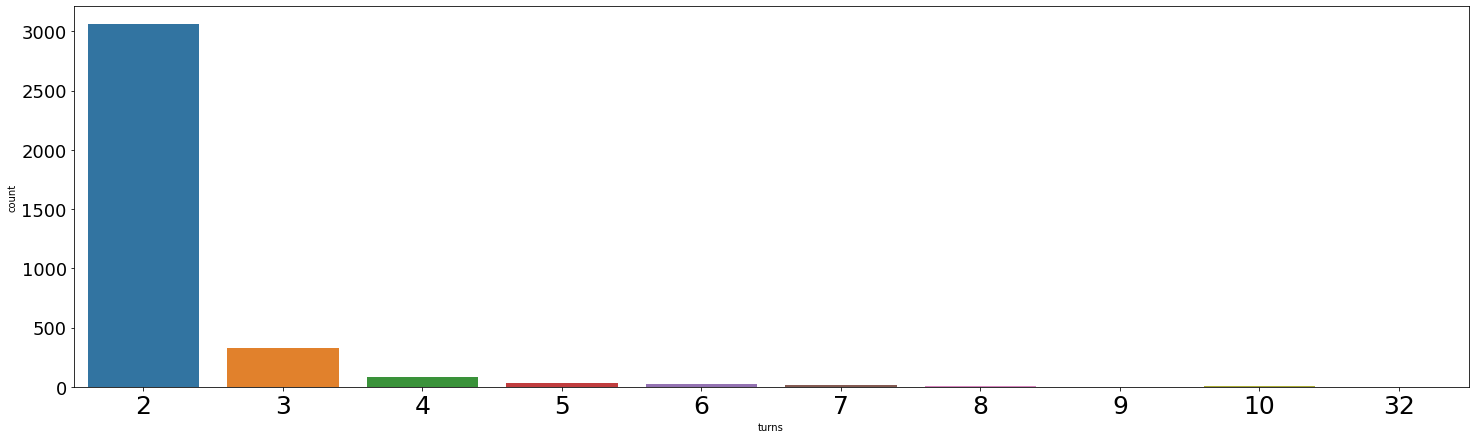

In [ ]:
# visualize
plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = sad_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in Sad')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = depression_dyadic_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in Depression')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = depressed_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in Depressed')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = offmychest_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in OffMyChest')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = suicidewatch_dyadic_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in SuicideWatch')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = depression_help_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in Depression_Help')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = anxietyhelp_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in AnxietyHelp')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'turns', y = 'count', data = mentalhealthsupport_dyadic_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Daydic Turn Distribution in MentalHealthSupport')
plt.show()

In [ ]:
# extract those with 10 or more dialog turns
sad_dyadic_convs_turn_10_more = extract_turn_10_more(sad_dyadic_convs_concise)
depression_dyadic_convs_turn_10_more = extract_turn_10_more(depression_dyadic_convs_concise)
depressed_dyadic_convs_turn_10_more = extract_turn_10_more(depressed_dyadic_convs_concise)
offmychest_dyadic_convs_turn_10_more = extract_turn_10_more(offmychest_dyadic_convs_concise)
suicidewatch_dyadic_convs_turn_10_more = extract_turn_10_more(suicidewatch_dyadic_convs_concise)
depression_help_dyadic_convs_turn_10_more = extract_turn_10_more(depression_help_dyadic_convs_concise)
anxietyhelp_dyadic_convs_turn_10_more = extract_turn_10_more(anxietyhelp_dyadic_convs_concise)
mentalhealthsupport_dyadic_convs_turn_10_more = extract_turn_10_more(mentalhealthsupport_dyadic_convs_concise)

In [ ]:
# save these samples
sad_dyadic_convs_turn_10_more.to_csv('more than 10 turns/sad.csv', index = False)
depression_dyadic_convs_turn_10_more.to_csv('more than 10 turns/depression.csv', index = False)
depressed_dyadic_convs_turn_10_more.to_csv('more than 10 turns/depressed.csv', index = False)
offmychest_dyadic_convs_turn_10_more.to_csv('more than 10 turns/offmychest.csv', index = False)
suicidewatch_dyadic_convs_turn_10_more.to_csv('more than 10 turns/suicidewatch.csv', index = False)
depression_help_dyadic_convs_turn_10_more.to_csv('more than 10 turns/depression_help.csv', index = False)
anxietyhelp_dyadic_convs_turn_10_more.to_csv('more than 10 turns/anxietyhelp.csv', index = False)
mentalhealthsupport_dyadic_convs_turn_10_more.to_csv('more than 10 turns/mentalhealthsupport.csv', index = False)

<a name="process-dyadic-profanity"></a>
### Remove Toxic Text
Use `profanity-check` to remove dirty words. Apart from that, remove the following dialog turns after the toxic responses.

In [ ]:
# load conversation data
sad_dyadic_convs_concise = pd.read_csv('conversations/sad_dyadic_convs_concise.csv', index_col=[0])
depression_dyadic_convs_concise = pd.read_csv('conversations/depression_dyadic_convs_concise.csv', index_col=[0])
depressed_dyadic_convs_concise = pd.read_csv('conversations/depressed_dyadic_convs_concise.csv', index_col=[0])
offmychest_dyadic_convs_concise = pd.read_csv('conversations/offmychest_dyadic_convs_concise.csv', index_col=[0])
suicidewatch_dyadic_convs_concise = pd.read_csv('conversations/suicidewatch_dyadic_convs_concise.csv', index_col=[0])
depression_help_dyadic_convs_concise = pd.read_csv('conversations/depression_help_dyadic_convs_concise.csv', index_col=[0])
anxietyhelp_dyadic_convs_concise = pd.read_csv('conversations/anxietyhelp_dyadic_convs_concise.csv', index_col=[0])
mentalhealthsupport_dyadic_convs_concise = pd.read_csv('conversations/mentalhealthsupport_dyadic_convs_concise.csv', index_col=[0])

In [ ]:
# remove newline tag
sad_dyadic_convs_concise = remove_newline(sad_dyadic_convs_concise)
depression_dyadic_convs_concise = remove_newline(depression_dyadic_convs_concise)
depressed_dyadic_convs_concise = remove_newline(depressed_dyadic_convs_concise)
offmychest_dyadic_convs_concise = remove_newline(offmychest_dyadic_convs_concise)
suicidewatch_dyadic_convs_concise = remove_newline(suicidewatch_dyadic_convs_concise)
depression_help_dyadic_convs_concise = remove_newline(depression_help_dyadic_convs_concise)
anxietyhelp_dyadic_convs_concise = remove_newline(anxietyhelp_dyadic_convs_concise)
mentalhealthsupport_dyadic_convs_concise = remove_newline(mentalhealthsupport_dyadic_convs_concise)

In [ ]:
# split clean and toxic
sad_dyadic_convs_clean, sad_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(sad_dyadic_convs_concise)
depression_dyadic_convs_clean, depression_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(depression_dyadic_convs_concise)
depressed_dyadic_convs_clean, depressed_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(depressed_dyadic_convs_concise)
offmychest_dyadic_convs_clean, offmychest_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(offmychest_dyadic_convs_concise)
suicidewatch_dyadic_convs_clean, suicidewatch_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(suicidewatch_dyadic_convs_concise)
depression_help_dyadic_convs_clean, depression_help_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(depression_help_dyadic_convs_concise)
anxietyhelp_dyadic_convs_clean, anxietyhelp_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(anxietyhelp_dyadic_convs_concise)
mentalhealthsupport_dyadic_convs_clean, mentalhealthsupport_dyadic_convs_toxic = differentiate_clean_toxic_convs_df(mentalhealthsupport_dyadic_convs_concise)

In [ ]:
# save dataframes
sad_dyadic_convs_clean.to_csv('sad_dyadic_convs_clean.csv', index = False)
sad_dyadic_convs_toxic.to_csv('sad_dyadic_convs_toxic.csv', index = False)
depression_dyadic_convs_clean.to_csv('depression_dyadic_convs_clean.csv', index = False)
depression_dyadic_convs_toxic.to_csv('depression_dyadic_convs_toxic.csv', index = False)
depressed_dyadic_convs_clean.to_csv('depressed_dyadic_convs_clean.csv', index = False)
depressed_dyadic_convs_toxic.to_csv('depressed_dyadic_convs_toxic.csv', index = False)
offmychest_dyadic_convs_clean.to_csv('offmychest_dyadic_convs_clean.csv', index = False)
offmychest_dyadic_convs_toxic.to_csv('offmychest_dyadic_convs_toxic.csv', index = False)
suicidewatch_dyadic_convs_clean.to_csv('suicidewatch_dyadic_convs_clean.csv', index = False)
suicidewatch_dyadic_convs_toxic.to_csv('suicidewatch_dyadic_convs_toxic.csv', index = False)
depression_help_dyadic_convs_clean.to_csv('depression_help_dyadic_convs_clean.csv', index = False)
depression_help_dyadic_convs_toxic.to_csv('depression_help_dyadic_convs_toxic.csv', index = False)
anxietyhelp_dyadic_convs_clean.to_csv('anxietyhelp_dyadic_convs_clean.csv', index = False)
anxietyhelp_dyadic_convs_toxic.to_csv('anxietyhelp_dyadic_convs_toxic.csv', index = False)
mentalhealthsupport_dyadic_convs_clean.to_csv('mentalhealthsupport_dyadic_convs_clean.csv', index = False)
mentalhealthsupport_dyadic_convs_toxic.to_csv('mentalhealthsupport_dyadic_convs_toxic.csv', index = False)

<a name="process-dyadic-recompute-stat"></a>
### Recompute the Descriptive Statistic

In [ ]:
# load dataframe
sad_dyadic_convs_clean = pd.read_csv('sad_dyadic_convs_clean.csv', lineterminator='\n')
sad_dyadic_convs_toxic = pd.read_csv('sad_dyadic_convs_toxic.csv', lineterminator='\n')
depression_dyadic_convs_clean = pd.read_csv('depression_dyadic_convs_clean.csv', lineterminator='\n')
depression_dyadic_convs_toxic = pd.read_csv('depression_dyadic_convs_toxic.csv', lineterminator='\n')
depressed_dyadic_convs_clean = pd.read_csv('depressed_dyadic_convs_clean.csv', lineterminator='\n')
depressed_dyadic_convs_toxic = pd.read_csv('depressed_dyadic_convs_toxic.csv', lineterminator='\n')
offmychest_dyadic_convs_clean = pd.read_csv('offmychest_dyadic_convs_clean.csv', lineterminator='\n')
offmychest_dyadic_convs_toxic = pd.read_csv('offmychest_dyadic_convs_toxic.csv', lineterminator='\n')
suicidewatch_dyadic_convs_clean = pd.read_csv('suicidewatch_dyadic_convs_clean.csv', lineterminator='\n')
suicidewatch_dyadic_convs_toxic = pd.read_csv('suicidewatch_dyadic_convs_toxic.csv', lineterminator='\n')
depression_help_dyadic_convs_clean = pd.read_csv('depression_help_dyadic_convs_clean.csv', lineterminator='\n')
depression_help_dyadic_convs_toxic = pd.read_csv('depression_help_dyadic_convs_toxic.csv', lineterminator='\n')
anxietyhelp_dyadic_convs_clean = pd.read_csv('anxietyhelp_dyadic_convs_clean.csv', lineterminator='\n')
anxietyhelp_dyadic_convs_toxic = pd.read_csv('anxietyhelp_dyadic_convs_toxic.csv', lineterminator='\n')
mentalhealthsupport_dyadic_convs_clean = pd.read_csv('mentalhealthsupport_dyadic_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_dyadic_convs_toxic = pd.read_csv('mentalhealthsupport_dyadic_convs_toxic.csv', lineterminator='\n')

In [ ]:
# compute tokens
sad_dyadic_clean_tokens = compute_tokens(sad_dyadic_convs_clean)
sad_dyadic_toxic_tokens = compute_tokens(sad_dyadic_convs_toxic)
depression_dyadic_clean_tokens = compute_tokens(depression_dyadic_convs_clean)
depression_dyadic_toxic_tokens = compute_tokens(depression_dyadic_convs_toxic)
depressed_dyadic_clean_tokens = compute_tokens(depressed_dyadic_convs_clean)
depressed_dyadic_toxic_tokens = compute_tokens(depressed_dyadic_convs_toxic)
offmychest_dyadic_clean_tokens = compute_tokens(offmychest_dyadic_convs_clean)
offmychest_dyadic_toxic_tokens = compute_tokens(offmychest_dyadic_convs_toxic)
suicidewatch_dyadic_clean_tokens = compute_tokens(suicidewatch_dyadic_convs_clean)
suicidewatch_dyadic_toxic_tokens = compute_tokens(suicidewatch_dyadic_convs_toxic)
depression_help_dyadic_clean_tokens = compute_tokens(depression_help_dyadic_convs_clean)
depression_help_dyadic_toxic_tokens = compute_tokens(depression_help_dyadic_convs_toxic)
anxietyhelp_dyadic_clean_tokens = compute_tokens(anxietyhelp_dyadic_convs_clean)
anxietyhelp_dyadic_toxic_tokens = compute_tokens(anxietyhelp_dyadic_convs_toxic)
mentalhealthsupport_dyadic_clean_tokens = compute_tokens(mentalhealthsupport_dyadic_convs_clean)
mentalhealthsupport_dyadic_toxic_tokens = compute_tokens(mentalhealthsupport_dyadic_convs_toxic)

In [ ]:
# calculate total number of tokens in the given subreddit
print(sum(depression_dyadic_clean_tokens.apply(len)))
print(sum(depression_dyadic_toxic_tokens.apply(len)))

106967833
1714401


<a name="process-dyadic-recompute-clean-toxic"></a>
### Recompute Totoal Number of Clean and Toxic Conversation Datasets

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_diags_clean = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(depressed_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(offmychest_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(sad_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(suicidewatch_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(depression_help_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(anxietyhelp_dyadic_convs_clean['conversation id'].unique()), 
                                                        len(mentalhealthsupport_dyadic_convs_clean['conversation id'].unique())]
})
subreddits_dyadic_diags_clean

,subreddit,length
0,depression,510035
1,depressed,10892
2,offmychest,437737
3,sad,18827
4,suicidewatch,262469
5,depression_help,23678
6,Anxietyhelp,8297
7,MentalHealthSupport,3551


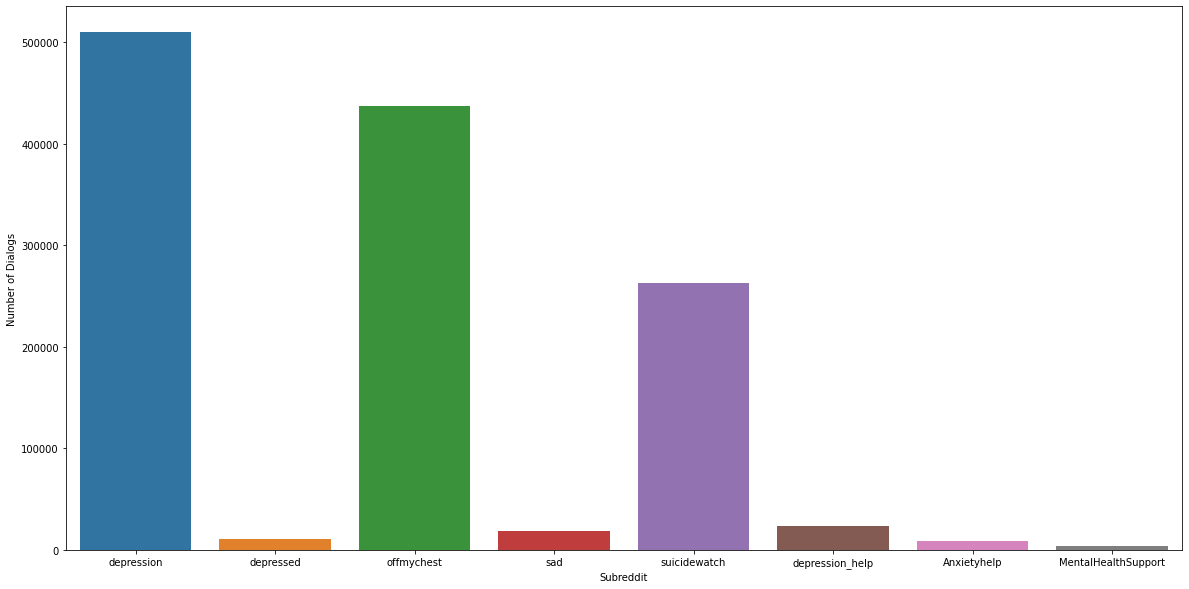

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_diags_clean)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_diags_toxic = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(depressed_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(offmychest_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(sad_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(suicidewatch_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(depression_help_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(anxietyhelp_dyadic_convs_toxic['conversation id'].unique()), 
                                                        len(mentalhealthsupport_dyadic_convs_toxic['conversation id'].unique())]
})
subreddits_dyadic_diags_toxic

,subreddit,length
0,depression,17871
1,depressed,308
2,offmychest,12790
3,sad,479
4,suicidewatch,11691
5,depression_help,347
6,Anxietyhelp,64
7,MentalHealthSupport,32


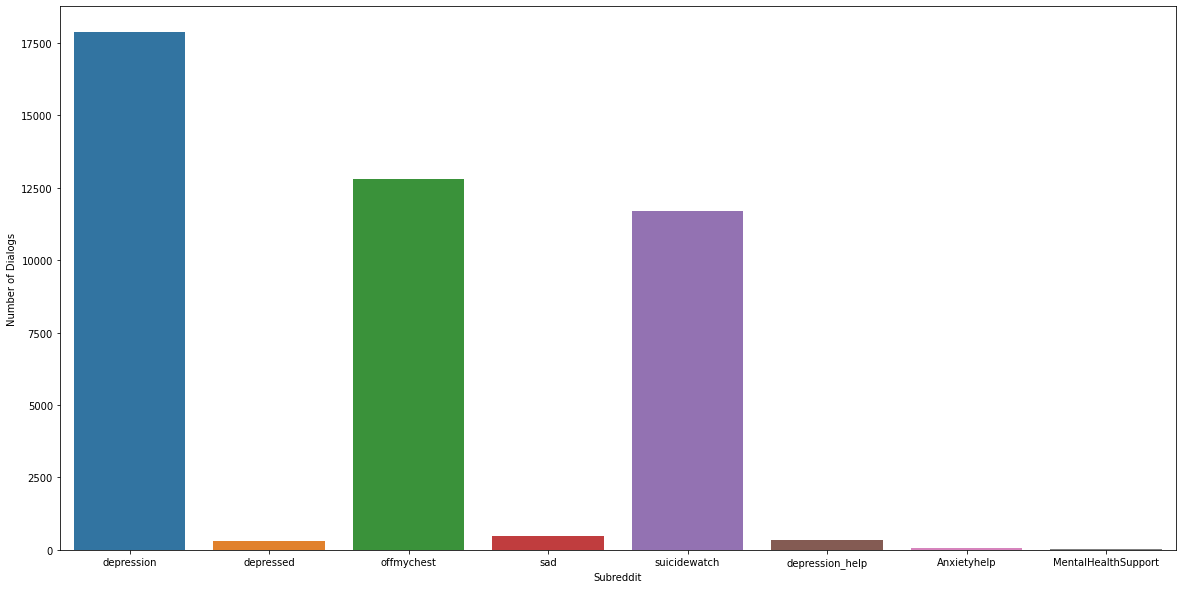

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_diags_toxic)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

<a name="process-dyadic-recompute-turn"></a>
### Recompute Total Number of Turns in Clean and Toxic Datasets

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_turns_clean = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_dyadic_convs_clean), 
                                                        len(depressed_dyadic_convs_clean), 
                                                        len(offmychest_dyadic_convs_clean), 
                                                        len(sad_dyadic_convs_clean), 
                                                        len(suicidewatch_dyadic_convs_clean), 
                                                        len(depression_help_dyadic_convs_clean), 
                                                        len(anxietyhelp_dyadic_convs_clean), 
                                                        len(mentalhealthsupport_dyadic_convs_clean)]
})

subreddits_dyadic_turns_clean

,subreddit,length
0,depression,1396044
1,depressed,23804
2,offmychest,1064467
3,sad,42293
4,suicidewatch,791737
5,depression_help,51849
6,Anxietyhelp,18351
7,MentalHealthSupport,7931


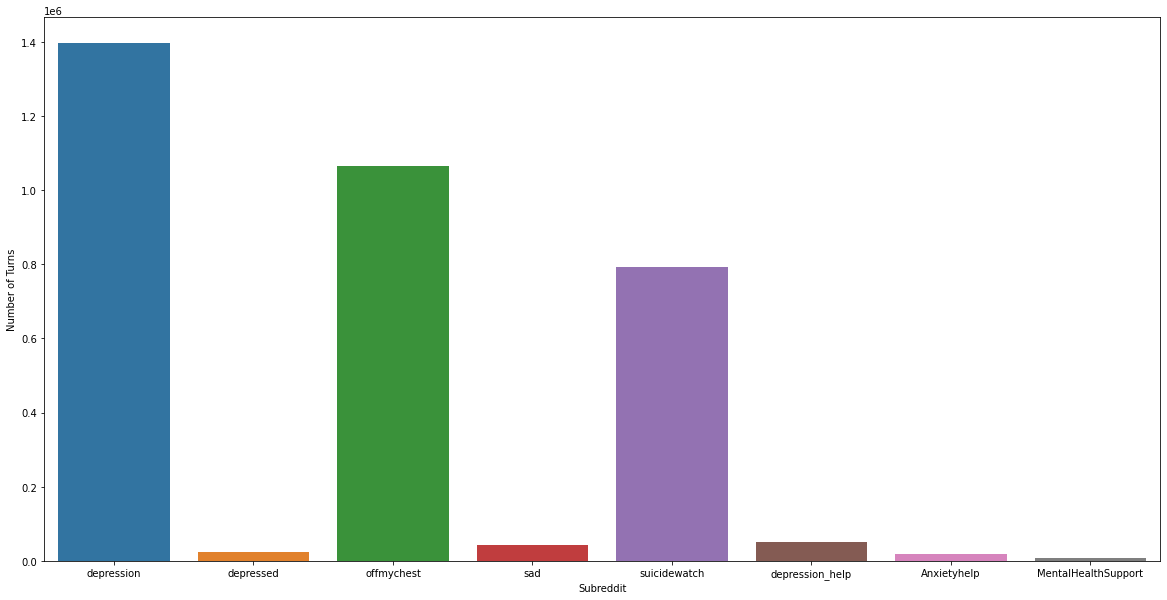

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_turns_clean)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_dyadic_turns_toxic = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_dyadic_convs_toxic), 
                                                        len(depressed_dyadic_convs_toxic), 
                                                        len(offmychest_dyadic_convs_toxic), 
                                                        len(sad_dyadic_convs_toxic), 
                                                        len(suicidewatch_dyadic_convs_toxic), 
                                                        len(depression_help_dyadic_convs_toxic), 
                                                        len(anxietyhelp_dyadic_convs_toxic), 
                                                        len(mentalhealthsupport_dyadic_convs_toxic)]
})

subreddits_dyadic_turns_toxic

,subreddit,length
0,depression,18855
1,depressed,316
2,offmychest,13168
3,sad,497
4,suicidewatch,12652
5,depression_help,357
6,Anxietyhelp,64
7,MentalHealthSupport,34


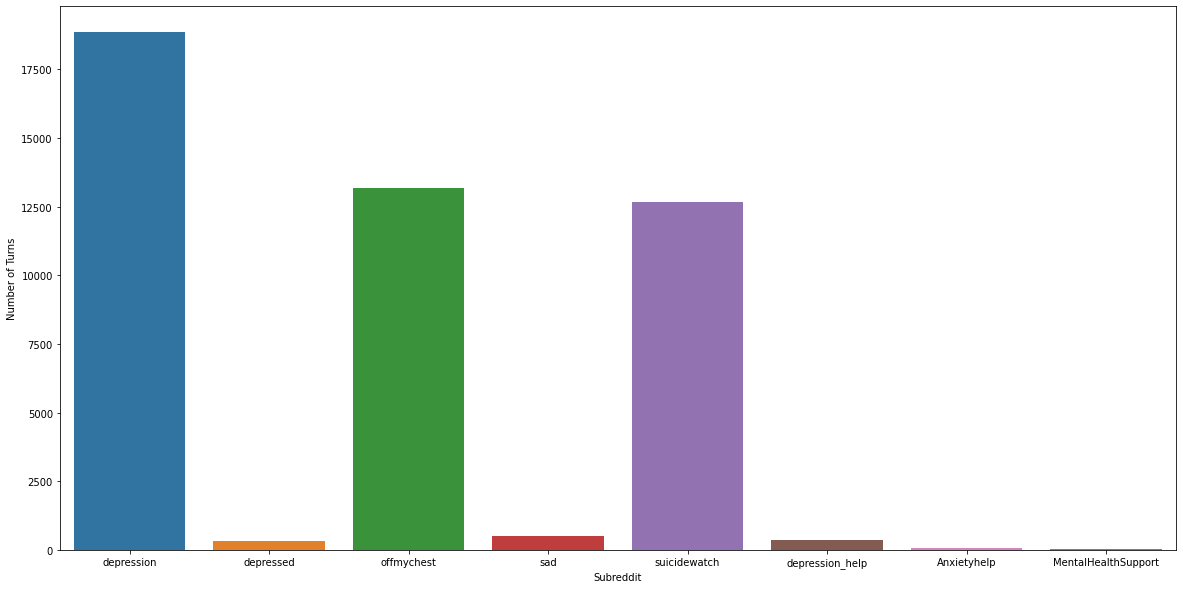

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_dyadic_turns_toxic)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

<a name="process-dyadic-frequent-word"></a>
### Frequent Words on Both Speaker and Listener on Cleaner Datasets.
**Warning**: The following cells will take very long time to run.

In [ ]:
# load cleaner dataframe
sad_dyadic_convs_clean = pd.read_csv('sad_dyadic_convs_clean.csv', lineterminator='\n')
depression_dyadic_convs_clean = pd.read_csv('depression_dyadic_convs_clean.csv', lineterminator='\n')
depressed_dyadic_convs_clean = pd.read_csv('depressed_dyadic_convs_clean.csv', lineterminator='\n')
offmychest_dyadic_convs_clean = pd.read_csv('offmychest_dyadic_convs_clean.csv', lineterminator='\n')
suicidewatch_dyadic_convs_clean = pd.read_csv('suicidewatch_dyadic_convs_clean.csv', lineterminator='\n')
depression_help_dyadic_convs_clean = pd.read_csv('depression_help_dyadic_convs_clean.csv', lineterminator='\n')
anxietyhelp_dyadic_convs_clean = pd.read_csv('anxietyhelp_dyadic_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_dyadic_convs_clean = pd.read_csv('mentalhealthsupport_dyadic_convs_clean.csv', lineterminator='\n')

In [ ]:
find_speaker_frequent_words(sad_dyadic_convs_clean, 20).to_csv('sad_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(sad_dyadic_convs_clean, 20).to_csv('sad_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depression_dyadic_convs_clean, 20).to_csv('depression_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depression_dyadic_convs_clean, 20).to_csv('depression_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(offmychest_dyadic_convs_clean, 20).to_csv('offmychest_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(offmychest_dyadic_convs_clean, 20).to_csv('offmychest_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(suicidewatch_dyadic_convs_clean, 20).to_csv('suicidewatch_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(suicidewatch_dyadic_convs_clean, 20).to_csv('suicidewatch_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depression_help_dyadic_convs_clean, 20).to_csv('depression_help_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depression_help_dyadic_convs_clean, 20).to_csv('depression_help_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(anxietyhelp_dyadic_convs_clean, 20).to_csv('anxietyhelp_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(anxietyhelp_dyadic_convs_clean, 20).to_csv('anxietyhelp_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depressed_dyadic_convs_clean, 20).to_csv('depressed_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depressed_dyadic_convs_clean, 20).to_csv('depressed_dyadic_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(mentalhealthsupport_dyadic_convs_clean, 20).to_csv('mentalhealthsupport_dyadic_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(mentalhealthsupport_dyadic_convs_clean, 20).to_csv('mentalhealthsupport_dyadic_listener_top20_freq_words.csv', index = False)

### Profanity Count on Speakers and Listeners

In [ ]:
# speaker profanity count
print(count_speaker_profanity(sad_dyadic_convs_concise))
print(count_speaker_profanity(depression_dyadic_convs_concise))
print(count_speaker_profanity(offmychest_dyadic_convs_concise))
print(count_speaker_profanity(suicidewatch_dyadic_convs_concise))
print(count_speaker_profanity(depression_help_dyadic_convs_concise))
print(count_speaker_profanity(depressed_dyadic_convs_concise))
print(count_speaker_profanity(anxietyhelp_dyadic_convs_concise))
print(count_speaker_profanity(mentalhealthsupport_dyadic_convs_concise))

1792
70526
78700
58986
1883
1491
197
222


In [ ]:
# listener profanity count
print(count_listener_profanity(sad_dyadic_convs_concise))
print(count_listener_profanity(depression_dyadic_convs_concise))
print(count_listener_profanity(offmychest_dyadic_convs_concise))
print(count_listener_profanity(suicidewatch_dyadic_convs_concise))
print(count_listener_profanity(depression_help_dyadic_convs_concise))
print(count_listener_profanity(depressed_dyadic_convs_concise))
print(count_listener_profanity(anxietyhelp_dyadic_convs_concise))
print(count_listener_profanity(mentalhealthsupport_dyadic_convs_concise))

497
18855
13168
12652
357
316
64
34


<a name="process-dyadic-lang-correct"></a>
### Language Correct
**Warning**: It will take much time for processing... Don't run this section unless it's needed.

In [ ]:
# load dataframe
sad_dyadic_convs_clean = pd.read_csv('sad_dyadic_convs_clean.csv', lineterminator='\n')
depression_dyadic_convs_clean = pd.read_csv('depression_dyadic_convs_clean.csv', lineterminator='\n')
depressed_dyadic_convs_clean = pd.read_csv('depressed_dyadic_convs_clean.csv', lineterminator='\n')
offmychest_dyadic_convs_clean = pd.read_csv('offmychest_dyadic_convs_clean.csv', lineterminator='\n')
suicidewatch_dyadic_convs_clean = pd.read_csv('suicidewatch_dyadic_convs_clean.csv', lineterminator='\n')
depression_help_dyadic_convs_clean = pd.read_csv('depression_help_dyadic_convs_clean.csv', lineterminator='\n')
anxietyhelp_dyadic_convs_clean = pd.read_csv('anxietyhelp_dyadic_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_dyadic_convs_clean = pd.read_csv('mentalhealthsupport_dyadic_convs_clean.csv', lineterminator='\n')

In [ ]:
# language correct
sad_dyadic_convs_clean_corrected = lang_correct(sad_dyadic_convs_clean, tool)
depression_dyadic_convs_clean_corrected = lang_correct(depression_dyadic_convs_clean, tool)
depressed_dyadic_convs_clean_corrected = lang_correct(depressed_dyadic_convs_clean, tool)
offmychest_dyadic_convs_clean_corrected = lang_correct(offmychest_dyadic_convs_clean, tool)
suicidewatch_dyadic_convs_clean_corrected = lang_correct(suicidewatch_dyadic_convs_clean, tool)
depression_help_dyadic_convs_clean_corrected = lang_correct(depression_help_dyadic_convs_clean, tool)
anxietyhelp_dyadic_convs_clean_corrected = lang_correct(anxietyhelp_dyadic_convs_clean, tool)
mentalhealthsupport_dyadic_convs_clean_corrected = lang_correct(mentalhealthsupport_dyadic_convs_clean, tool)

In [ ]:
# save
sad_dyadic_convs_clean_corrected.to_csv('sad_dyadic_convs_clean_corrected.csv', index = False)
depression_dyadic_convs_clean_corrected.to_csv('depression_dyadic_convs_clean_corrected.csv', index = False)
depressed_dyadic_convs_clean_corrected.to_csv('depressed_dyadic_convs_clean_corrected.csv', index = False)
offmychest_dyadic_convs_clean_corrected.to_csv('offmychest_dyadic_convs_clean_corrected.csv', index = False)
suicidewatch_dyadic_convs_clean_corrected.to_csv('suicidewatch_dyadic_convs_clean_corrected.csv', index = False)
depression_help_dyadic_convs_clean_corrected.to_csv('depression_help_dyadic_convs_clean_corrected.csv', index = False)
anxietyhelp_dyadic_convs_clean_corrected.to_csv('anxietyhelp_dyadic_convs_clean_corrected.csv', index = False)
mentalhealthsupport_dyadic_convs_clean_corrected.to_csv('mentalhealthsupport_dyadic_convs_clean_corrected.csv', index = False)

<a name="process-dyadic-sentiment"></a>
### Sentiment Analysis
Apply `Vader` to perform sentiment analysis on speaker and listener words respectively.

In [ ]:
# add sentiment to the original dataframe
sad_dyadic_convs_clean = compute_sentiment(sad_dyadic_convs_clean)
depression_dyadic_convs_clean = compute_sentiment(depression_dyadic_convs_clean)
depressed_dyadic_convs_clean = compute_sentiment(depressed_dyadic_convs_clean)
offmychest_dyadic_convs_clean = compute_sentiment(offmychest_dyadic_convs_clean)
suicidewatch_dyadic_convs_clean = compute_sentiment(suicidewatch_dyadic_convs_clean)
depression_help_dyadic_convs_clean = compute_sentiment(depression_help_dyadic_convs_clean)
anxietyhelp_dyadic_convs_clean = compute_sentiment(anxietyhelp_dyadic_convs_clean)
mentalhealthsupport_dyadic_convs_clean = compute_sentiment(mentalhealthsupport_dyadic_convs_clean)

In [ ]:
# save
sad_dyadic_convs_clean.to_csv('sad_dyadic_convs_clean_sentiment.csv', index = False)
depression_dyadic_convs_clean.to_csv('depression_dyadic_convs_clean_sentiment.csv', index = False)
depressed_dyadic_convs_clean.to_csv('depressed_dyadic_convs_clean_sentiment.csv', index = False)
offmychest_dyadic_convs_clean.to_csv('offmychest_dyadic_convs_clean_sentiment.csv', index = False)
suicidewatch_dyadic_convs_clean.to_csv('suicidewatch_dyadic_convs_clean_sentiment.csv', index = False)
depression_help_dyadic_convs_clean.to_csv('depression_help_dyadic_convs_clean_sentiment.csv', index = False)
anxietyhelp_dyadic_convs_clean.to_csv('anxietyhelp_dyadic_convs_clean_sentiment.csv', index = False)
mentalhealthsupport_dyadic_convs_clean.to_csv('mentalhealthsupport_dyadic_convs_clean_sentiment.csv', index = False)

In [ ]:
# load data
sad_dyadic_convs_clean = pd.read_csv('sad_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
depression_dyadic_convs_clean = pd.read_csv('depression_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
depressed_dyadic_convs_clean = pd.read_csv('depressed_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
offmychest_dyadic_convs_clean = pd.read_csv('offmychest_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
suicidewatch_dyadic_convs_clean = pd.read_csv('suicidewatch_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
depression_help_dyadic_convs_clean = pd.read_csv('depression_help_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
anxietyhelp_dyadic_convs_clean = pd.read_csv('anxietyhelp_dyadic_convs_clean_sentiment.csv', lineterminator='\n')
mentalhealthsupport_dyadic_convs_clean = pd.read_csv('mentalhealthsupport_dyadic_convs_clean_sentiment.csv', lineterminator='\n')

In [ ]:
# compute sentiment count from speaker and listener
total_speaker_sentiment_dyadic_convs = speaker_sentiment_count(sad_dyadic_convs_clean)\
                                        + speaker_sentiment_count(depression_dyadic_convs_clean)\
                                        + speaker_sentiment_count(depressed_dyadic_convs_clean)\
                                        + speaker_sentiment_count(offmychest_dyadic_convs_clean)\
                                        + speaker_sentiment_count(suicidewatch_dyadic_convs_clean)\
                                        + speaker_sentiment_count(depression_help_dyadic_convs_clean)\
                                        + speaker_sentiment_count(anxietyhelp_dyadic_convs_clean)\
                                        + speaker_sentiment_count(mentalhealthsupport_dyadic_convs_clean)

total_listener_sentiment_dyadic_convs = listener_sentiment_count(sad_dyadic_convs_clean)\
                                        + listener_sentiment_count(depression_dyadic_convs_clean)\
                                        + listener_sentiment_count(depressed_dyadic_convs_clean)\
                                        + listener_sentiment_count(offmychest_dyadic_convs_clean)\
                                        + listener_sentiment_count(suicidewatch_dyadic_convs_clean)\
                                        + listener_sentiment_count(depression_help_dyadic_convs_clean)\
                                        + listener_sentiment_count(anxietyhelp_dyadic_convs_clean)\
                                        + listener_sentiment_count(mentalhealthsupport_dyadic_convs_clean)

<Figure size 1440x720 with 0 Axes>

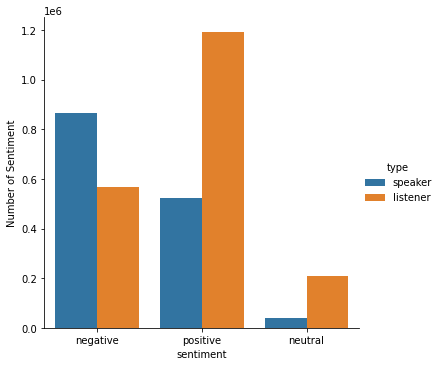

In [ ]:
# transform to dataframe
total_speaker_sentiment_dyadic_convs_df = pd.DataFrame(total_speaker_sentiment_dyadic_convs)\
                                            .reset_index().rename(columns = {'index': 'sentiment', 'sentiment': 'count'})

total_listener_sentiment_dyadic_convs_df = pd.DataFrame(total_listener_sentiment_dyadic_convs)\
                                            .reset_index().rename(columns = {'index': 'sentiment', 'sentiment': 'count'})

# add type
total_speaker_sentiment_dyadic_convs_df['type'] = 'speaker'
total_listener_sentiment_dyadic_convs_df['type'] = 'listener'

# combine both 
total_sentiment_dyadic_convs_df = pd.concat([total_speaker_sentiment_dyadic_convs_df, 
                                            total_listener_sentiment_dyadic_convs_df])\
                                            .reset_index().drop('index', axis = 1)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'sentiment', y = 'count', hue = 'type', data = total_sentiment_dyadic_convs_df, kind = 'bar')
plt.ylabel('Number of Sentiment')
plt.show()

<a name="process-multi"></a>
## Processing **Multiparty** Conversations
In this part, process the data on those with multiparty conversations. Unlike dyadic ones, multiparty conversations involves more commenters (listeners) in a conversation.

In [ ]:
# load multiparty dataframes combined posts and comments
sad_multi_convs = pd.read_csv('sad_multi_convs.csv').drop_duplicates().drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).dropna(subset= ['post_content', 'comment_content'])
depressed_multi_convs = pd.read_csv('depressed_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
depression_multi_convs = pd.read_csv('depression_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
offmychest_multi_convs = pd.read_csv('offmychest_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
suicidewatch_multi_convs = pd.read_csv('suicidewatch_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
depression_help_multi_convs = pd.read_csv('depression_help_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
anxietyhelp_multi_convs = pd.read_csv('Anxietyhelp_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])
mentalhealthsupport_multi_convs = pd.read_csv('MentalHealthSupport_multi_convs.csv').drop_duplicates().drop('Unnamed: 0', axis = 1).dropna(subset= ['post_content', 'comment_content'])

<a name="process-multi-concise"></a>
### Build a Concise Conversation Dataframe
In this part, the original dataframe will be reconstructed to make a more concise version of a conversation dataframe. And this dataframe will then be used to analyze the tokens.

In [ ]:
# set up multiprocessing unit
pool = mp.Pool(16)

# build more concise conversation dataframes specified by Supervisor
depression_multi_convs_concise = (pool.apply_async(build_convs, [depression_multi_convs])).get()
depressed_multi_convs_concise = (pool.apply_async(build_convs, [depressed_multi_convs])).get()
offmychest_multi_convs_concise = (pool.apply_async(build_convs, [offmychest_multi_convs])).get()
suicidewatch_multi_convs_concise = (pool.apply_async(build_convs, [suicidewatch_multi_convs])).get()
sad_multi_convs_concise = (pool.apply_async(build_convs, [sad_multi_convs])).get()
depression_help_multi_convs_concise = (pool.apply_async(build_convs, [depression_help_multi_convs])).get()
anxietyhelp_multi_convs_concise = (pool.apply_async(build_convs, [anxietyhelp_multi_convs])).get()
mentalhealthsupport_multi_convs_concise = (pool.apply_async(build_convs, [mentalhealthsupport_multi_convs])).get()

In [ ]:
# build more concise conversation dataframes specified by Supervisor (parallel -- > much faster)
depression_multi_convs_concise = build_concise_convs_df(depression_multi_convs)
depressed_multi_convs_concise = build_concise_convs_df(depressed_multi_convs)
offmychest_multi_convs_concise = build_concise_convs_df(offmychest_multi_convs)
suicidewatch_multi_convs_concise = build_concise_convs_df(suicidewatch_multi_convs)
sad_multi_convs_concise = build_concise_convs_df(sad_multi_convs)
depression_help_multi_convs_concise = build_concise_convs_df(depression_help_multi_convs)
anxietyhelp_multi_convs_concise = build_concise_convs_df(anxietyhelp_multi_convs)
mentalhealthsupport_multi_convs_concise = build_concise_convs_df(mentalhealthsupport_multi_convs)

In [ ]:
depressed_multi_convs_concise = depressed_multi_convs_concise.reset_index().drop('index', axis = 1)
anxietyhelp_multi_convs_concise = anxietyhelp_multi_convs_concise.reset_index().drop('index', axis = 1)
mentalhealthsupport_multi_convs_concise = mentalhealthsupport_multi_convs_concise.reset_index().drop('index', axis = 1)

mentalhealthsupport_multi_convs_concise

,conversation id,subreddit,post title,author,dialog turn,text
0,1,MentalHealthSupport,[BPD] Difficulty in avoiding drama,I_Am_Jacks_BPD,1,*** **All names have been changed to protect t...
1,1,MentalHealthSupport,[BPD] Difficulty in avoiding drama,saaiirr,2,You can't control someone else's behavior.\n\n...
2,1,MentalHealthSupport,[BPD] Difficulty in avoiding drama,I_Am_Jacks_BPD,3,I totally understand all of that. It's the rea...
3,1,MentalHealthSupport,[BPD] Difficulty in avoiding drama,redsaidfred,4,I have a bad habit of completely cutting peopl...
4,1,MentalHealthSupport,[BPD] Difficulty in avoiding drama,I_Am_Jacks_BPD,5,At least you're aware that you do it and that ...
...,...,...,...,...,...,...
5941,1077,MentalHealthSupport,"25/ftm/UK suffering from anxiety, depression. ...",Lil_KSA,2,I’m really sorry. This fucking virus has 100% ...
5942,1077,MentalHealthSupport,"25/ftm/UK suffering from anxiety, depression. ...",rogersmith1965,3,That is good to hear! I am still here if you n...
5943,1078,MentalHealthSupport,I feel like a failure.,in-other_wordzzz,1,"I have OCD, anxiety, and major depressive diso..."
5944,1078,MentalHealthSupport,I feel like a failure.,radicalzb,2,Hey! Sorry for the incredibly late reply on th...


In [ ]:
# save dataframe
mentalhealthsupport_multi_convs_concise.to_csv('mentalhealthsupport_multi_convs_concise.csv')

<a name="process-multi-tokenize"></a>
### Tokenize and Lemmatize
In this part, the raw texts from posts and comments would be processed to keep only the meaningful words. That is, unnecessary marks and stopwords will be removed. 

In [ ]:
# load conversation sets
subreddit_multi_convs_concise = pd.read_csv('depression_multi_convs_concise.csv', index_col=[0])
subreddit_multi_convs_concise

,conversation id,subreddit,post title,author,dialog turn,text
0,1,depression,All I know how to be anymore is a giant useles...,AwkwardRecluse,1,I don't even know why I'm doing this. I've jus...
1,1,depression,All I know how to be anymore is a giant useles...,lurkerasifhagaws,2,Just posting to say I read it and give you a b...
2,1,depression,All I know how to be anymore is a giant useles...,AwkwardRecluse,3,That's the thing. I've spoken with her about i...
3,1,depression,All I know how to be anymore is a giant useles...,AwkwardRecluse,4,"That's interesting, because I'm going on about..."
4,1,depression,All I know how to be anymore is a giant useles...,tuna1979,5,Sometimes therapy isn't enough. I had to get m...
...,...,...,...,...,...,...
1840076,246267,depression,I’m tired.,Princess_Siren,3,"I am, thank you for checking in on me!! I hope..."
1840077,246268,depression,Medication has slowly been ruining my life,retromilitary,1,I was diagnosed with severe Attention Deficit ...
1840078,246268,depression,Medication has slowly been ruining my life,pz6c,2,Have you tried coming off for a period since f...
1840079,246268,depression,Medication has slowly been ruining my life,retromilitary,3,"Thank you, u/shrekthecumslut :)"


In [ ]:
subreddit_multi_tokens = compute_tokens(subreddit_multi_convs_concise)
subreddit_multi_tokens

0          [I, even, know, I, ., I, particularly, rough, ...
1          [Just, post, say, I, read, give, NONWORD, ., H...
2          [thing, ., I, spoken, past, gotten, point, get...
3          [interest, ,, I, go, NUM, year, consistent, de...
4          [Sometimes, therapy, enough, ., I, get, medica...
                                 ...                        
1840076    [I, ,, thank, check, !, !, I, hope, good, well...
1840077    [I, diagnose, severe, Attention, Deficit, Diso...
1840078    [Have, try, come, period, since, fifth, grade, ?]
1840079                            [Thank, ,, NONWORD, :, )]
1840080                    [No, prob, lol, Edit, :, real, ?]
Name: text, Length: 1840081, dtype: object

In [ ]:
# calculate total number of tokens in the given subreddit
sum(subreddit_multi_tokens.apply(len))

85673795

<a name="process-multi-dialog"></a>
### Total Number of Dialogs
For each subreddit, compute the total number of dyadic dialogs and compare it via visualizing a bar chart.

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_diags = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                          'length': [len(depression_multi_convs.link_id.unique()), 
                                     len(depressed_multi_convs.link_id.unique()), 
                                     len(offmychest_multi_convs.link_id.unique()), 
                                     len(sad_multi_convs.link_id.unique()), 
                                     len(suicidewatch_multi_convs.link_id.unique()), 
                                     len(depression_help_multi_convs.link_id.unique()), 
                                     len(anxietyhelp_multi_convs.link_id.unique()), 
                                     len(mentalhealthsupport_multi_convs.link_id.unique())]
})

subreddits_multi_diags

,subreddit,length
0,depression,271194
1,depressed,3584
2,offmychest,204862
3,sad,7099
4,suicidewatch,137438
5,depression_help,8190
6,Anxietyhelp,3075
7,MentalHealthSupport,1099


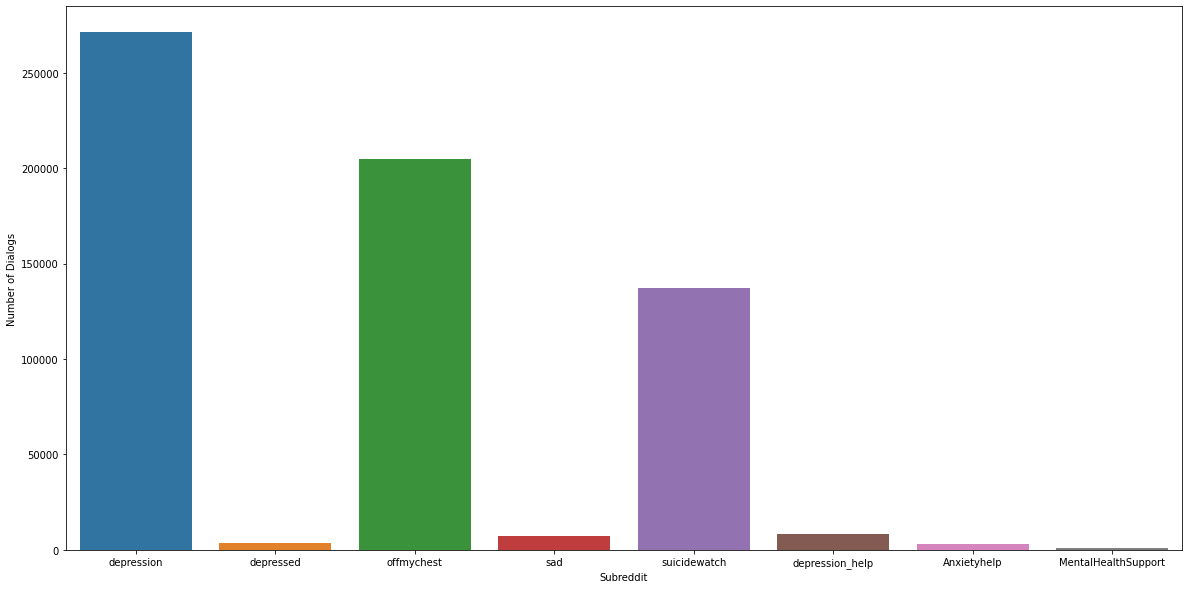

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_diags)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

<a name="process-multi-turn"></a>
### Total Number of Turns
For each subreddit, compute the total number of turns and compare it via visualizing a bar chart. Note that each post or comment can be counted as a turn.

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_turns = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                          'length': [len(depression_multi_convs) + len(depression_multi_convs.link_id.unique()), 
                                     len(depressed_multi_convs) + len(depressed_multi_convs.link_id.unique()), 
                                     len(offmychest_multi_convs) + len(offmychest_multi_convs.link_id.unique()), 
                                     len(sad_multi_convs) + len(sad_multi_convs.link_id.unique()), 
                                     len(suicidewatch_multi_convs) + len(suicidewatch_multi_convs.link_id.unique()), 
                                     len(depression_help_multi_convs) + len(depression_help_multi_convs.link_id.unique()), 
                                     len(anxietyhelp_multi_convs) + len(anxietyhelp_multi_convs.link_id.unique()), 
                                     len(mentalhealthsupport_multi_convs) + len(mentalhealthsupport_multi_convs.link_id.unique())]
})

subreddits_multi_turns

,subreddit,length
0,depression,1840081
1,depressed,19776
2,offmychest,1486404
3,sad,37192
4,suicidewatch,1030317
5,depression_help,47629
6,Anxietyhelp,17299
7,MentalHealthSupport,5946


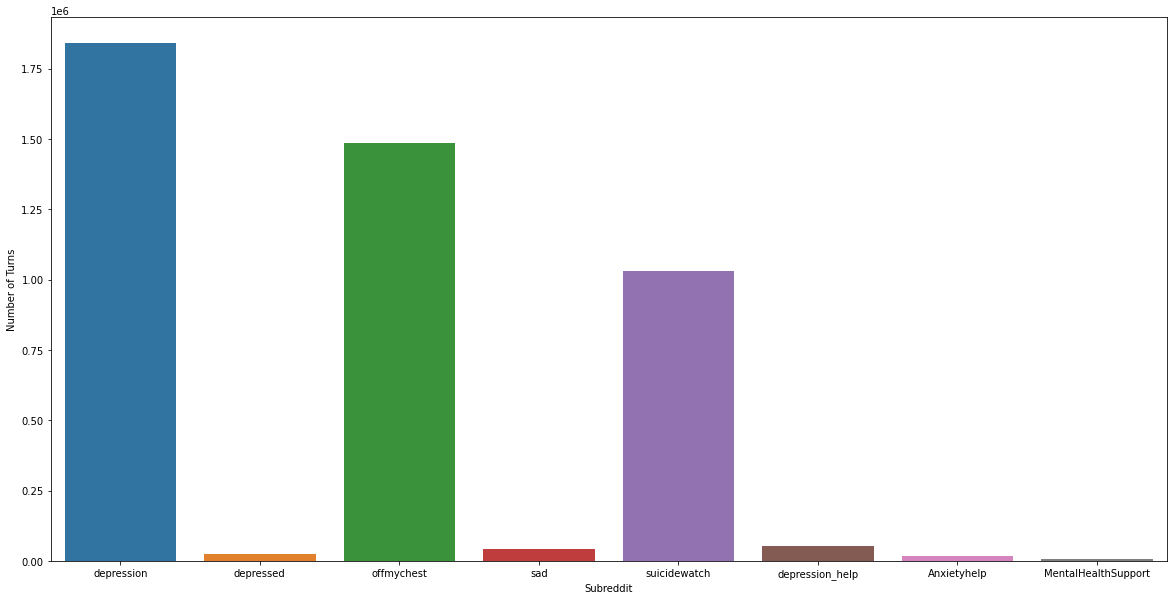

In [ ]:
# plot
plt.figure(figsize = (20, 10))

sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_turns)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

<a name="process-multi-distribution"></a>
### Turns Distribution in Each Subreddit
The number of turns inside the conversations in a given subreddit varies. Here we visualize the distribution using a histogram to show how conversation turns distribute.

In [ ]:
sad_multi_convs_concise = pd.read_csv('conversations/sad_multi_convs_concise.csv', index_col=[0])
depression_multi_convs_concise = pd.read_csv('conversations/depression_multi_convs_concise.csv', index_col=[0])
depressed_multi_convs_concise = pd.read_csv('conversations/depressed_multi_convs_concise.csv', index_col=[0])
offmychest_multi_convs_concise = pd.read_csv('conversations/offmychest_multi_convs_concise.csv', index_col=[0])
suicidewatch_multi_convs_concise = pd.read_csv('conversations/suicidewatch_multi_convs_concise.csv', index_col=[0])
depression_help_multi_convs_concise = pd.read_csv('conversations/depression_help_multi_convs_concise.csv', index_col=[0])
anxietyhelp_multi_convs_concise = pd.read_csv('conversations/anxietyhelp_multi_convs_concise.csv', index_col=[0])
mentalhealthsupport_multi_convs_concise = pd.read_csv('conversations/mentalhealthsupport_multi_convs_concise.csv', index_col=[0])

In [ ]:
sad_multi_convs_turn_dist = compute_turn_distribution(sad_multi_convs_concise)
depression_multi_convs_turn_dist = compute_turn_distribution(depression_multi_convs_concise)
depressed_multi_convs_turn_dist = compute_turn_distribution(depressed_multi_convs_concise)
offmychest_multi_convs_turn_dist = compute_turn_distribution(offmychest_multi_convs_concise)
suicidewatch_multi_convs_turn_dist = compute_turn_distribution(suicidewatch_multi_convs_concise)
depression_help_multi_convs_turn_dist = compute_turn_distribution(depression_help_multi_convs_concise)
anxietyhelp_multi_convs_turn_dist = compute_turn_distribution(anxietyhelp_multi_convs_concise)
mentalhealthsupport_multi_convs_turn_dist = compute_turn_distribution(mentalhealthsupport_multi_convs_concise)

In [ ]:
depression_multi_convs_turn_dist

,turns,count,type
0,3,65760,3
1,4,49795,4
2,5,27042,5
3,6,21951,6
4,7,15545,7
...,...,...,...
223,2447,1,larger than 100
224,2840,1,larger than 100
225,3629,1,larger than 100
226,3671,1,larger than 100


In [ ]:
def check_turn(turn):
    if turn <= 100:
        result = str(turn)
    else:
        result = '> 100'
    
    return result

sad_multi_convs_turn_dist['type'] = sad_multi_convs_turn_dist['turns'].apply(check_turn)
depression_multi_convs_turn_dist['type'] = depression_multi_convs_turn_dist['turns'].apply(check_turn)
depressed_multi_convs_turn_dist['type'] = depressed_multi_convs_turn_dist['turns'].apply(check_turn)
suicidewatch_multi_convs_turn_dist['type'] = suicidewatch_multi_convs_turn_dist['turns'].apply(check_turn)
offmychest_multi_convs_turn_dist['type'] = offmychest_multi_convs_turn_dist['turns'].apply(check_turn)
depression_help_multi_convs_turn_dist['type'] = depression_help_multi_convs_turn_dist['turns'].apply(check_turn)
anxietyhelp_multi_convs_turn_dist['type'] = anxietyhelp_multi_convs_turn_dist['turns'].apply(check_turn)
mentalhealthsupport_multi_convs_turn_dist['type'] = mentalhealthsupport_multi_convs_turn_dist['turns'].apply(check_turn)

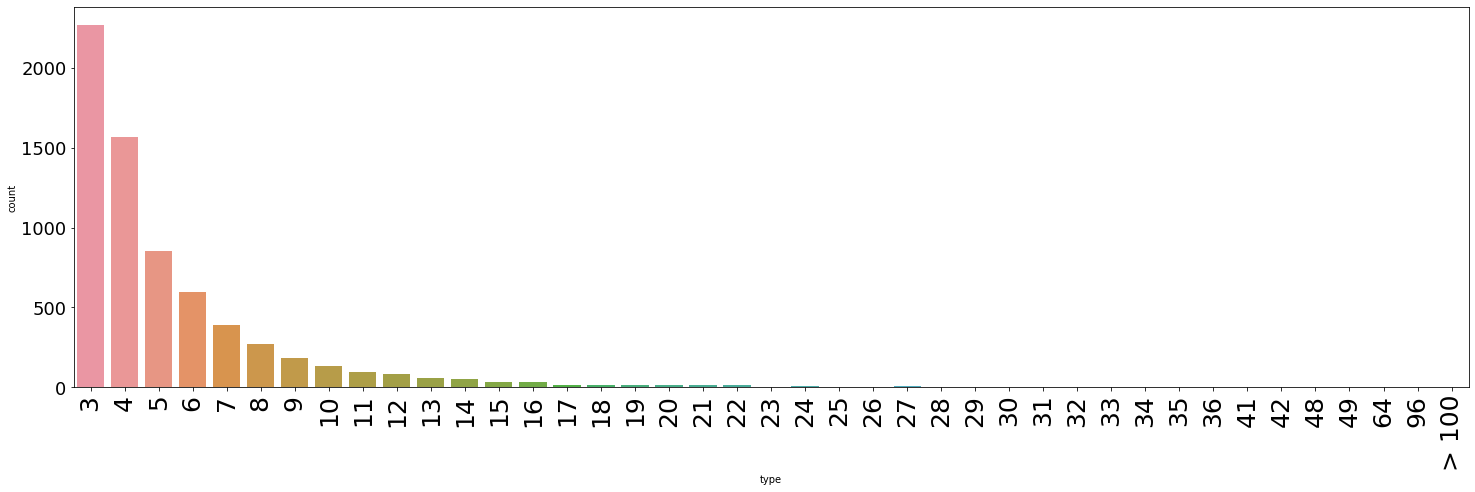

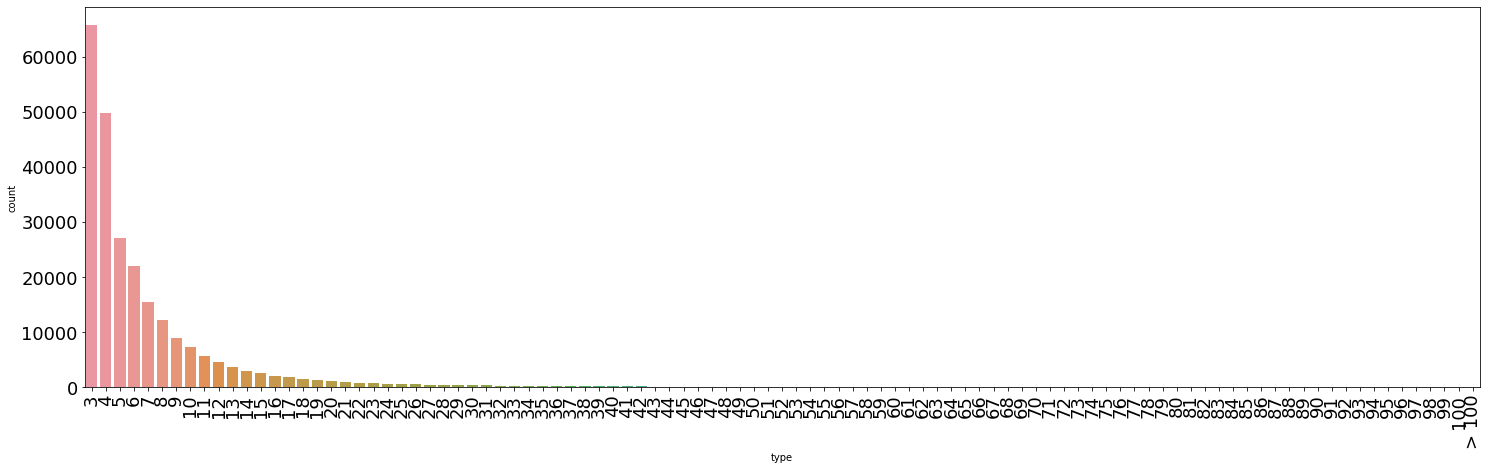

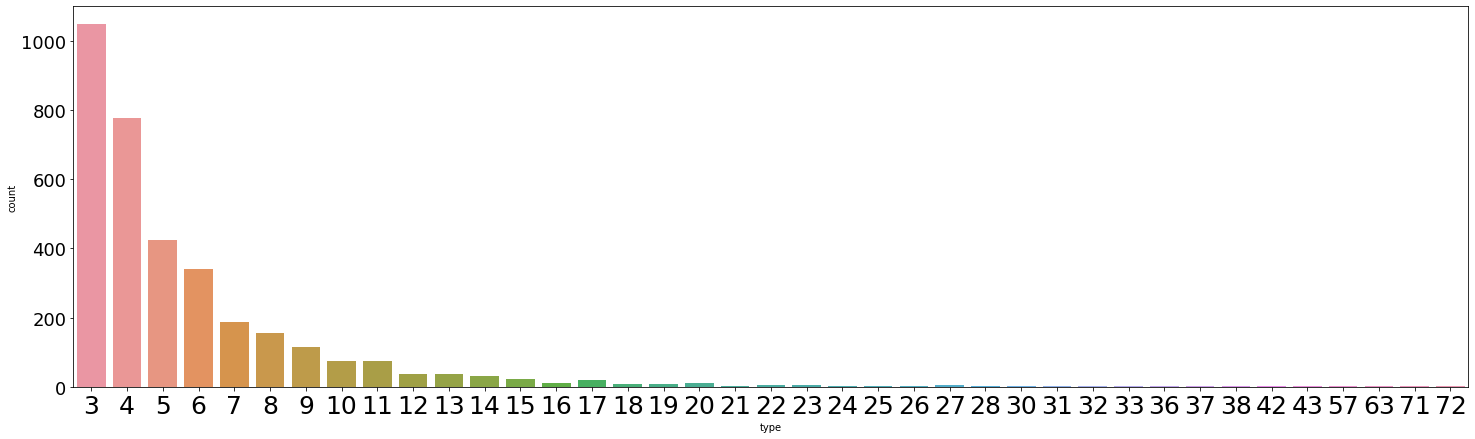

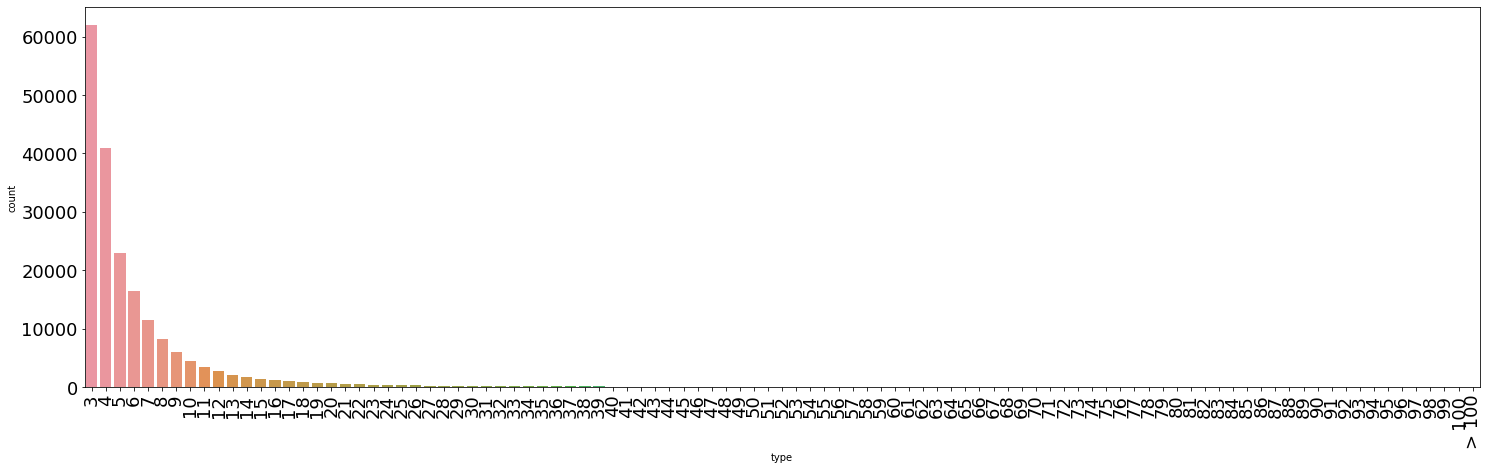

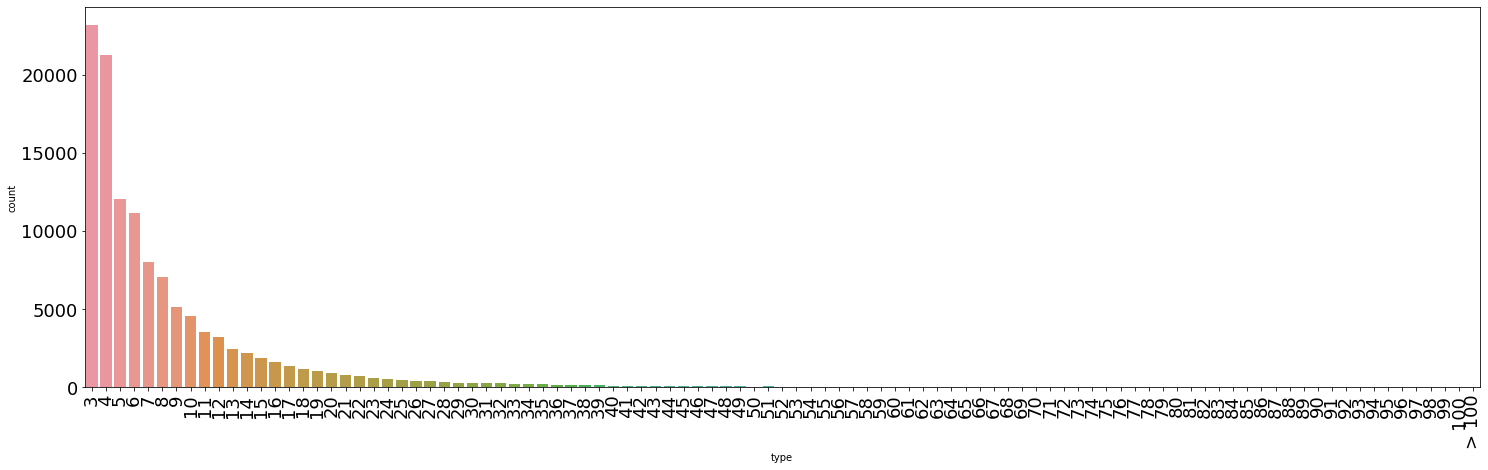

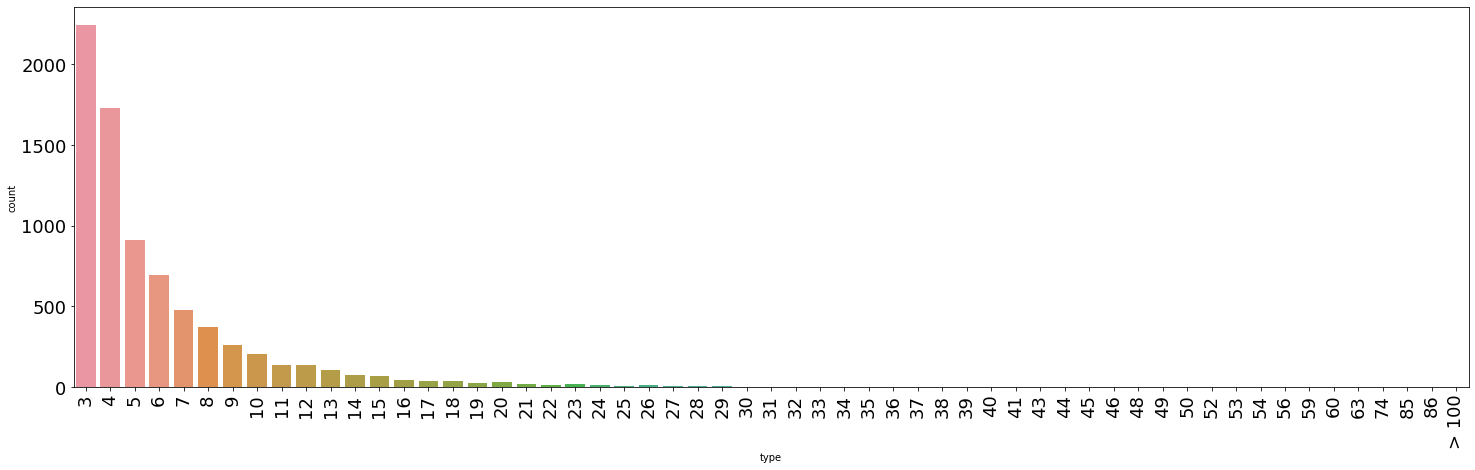

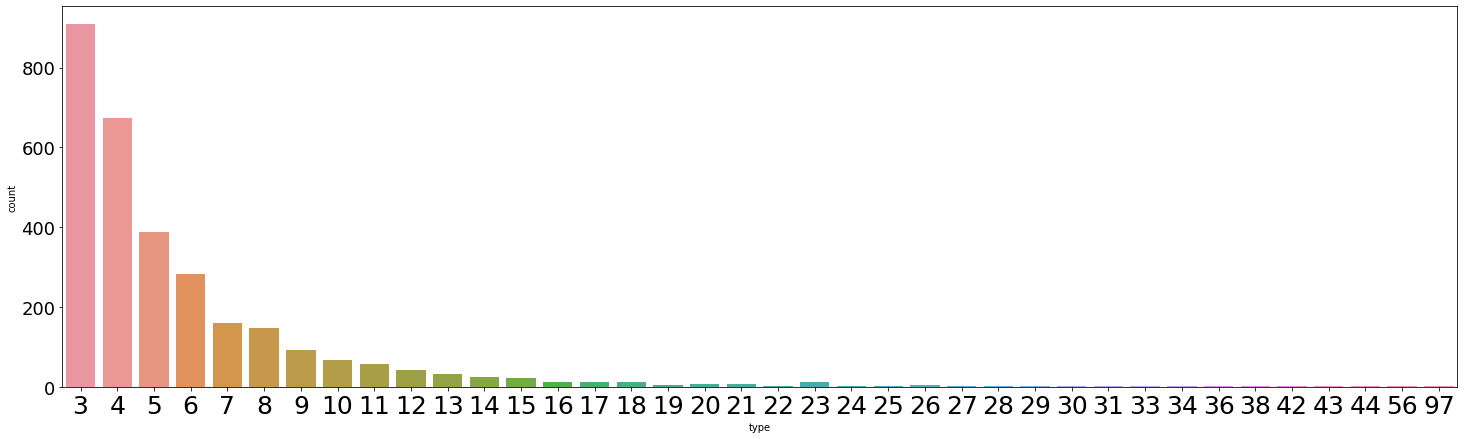

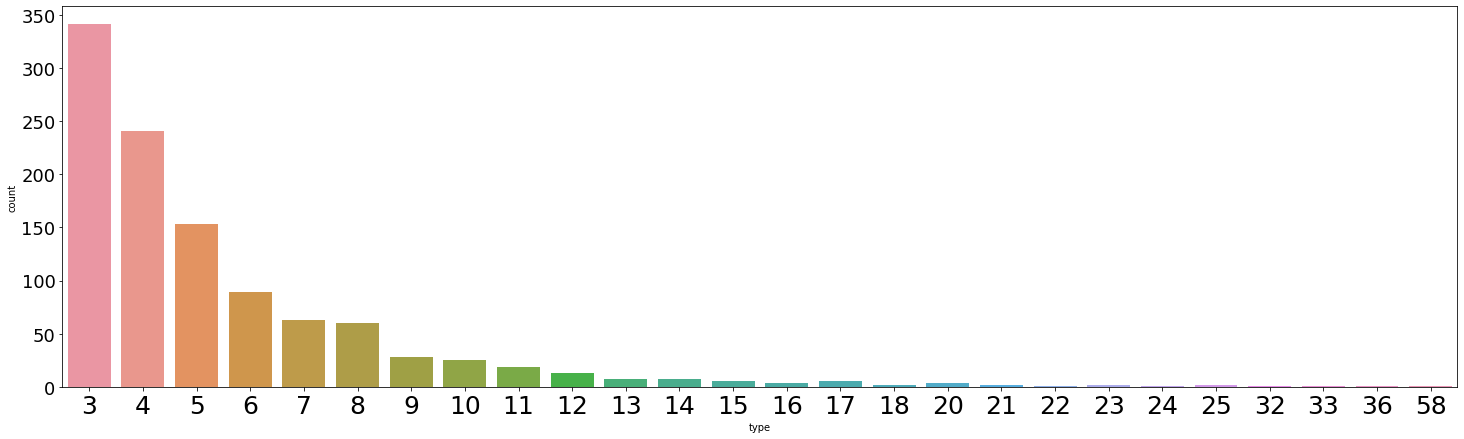

In [ ]:
# visualize
plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = sad_multi_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in Sad')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = depression_multi_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in Depression')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = depressed_multi_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in Depressed')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = offmychest_multi_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in OffMyChest')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = suicidewatch_multi_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in SuicideWatch')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = depression_help_multi_convs_turn_dist)
plt.xticks(rotation = 90, fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in Depression_Help')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = anxietyhelp_multi_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in AnxietyHelp')
plt.show()

plt.figure(figsize = (25, 7))
sns.barplot(x = 'type', y = 'count', data = mentalhealthsupport_multi_convs_turn_dist)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 18)
plt.savefig('Multiparty Turn Distribution in MentalHealthSupport')
plt.show()

In [ ]:
# extract those with 10 or more dialog turns
sad_multi_convs_turn_10_more = extract_turn_10_more(sad_multi_convs_concise)
depression_multi_convs_turn_10_more = extract_turn_10_more(depression_multi_convs_concise)
depressed_multi_convs_turn_10_more = extract_turn_10_more(depressed_multi_convs_concise)
offmychest_multi_convs_turn_10_more = extract_turn_10_more(offmychest_multi_convs_concise)
suicidewatch_multi_convs_turn_10_more = extract_turn_10_more(suicidewatch_multi_convs_concise)
depression_help_multi_convs_turn_10_more = extract_turn_10_more(depression_help_multi_convs_concise)
anxietyhelp_multi_convs_turn_10_more = extract_turn_10_more(anxietyhelp_multi_convs_concise)
mentalhealthsupport_multi_convs_turn_10_more = extract_turn_10_more(mentalhealthsupport_multi_convs_concise)

In [ ]:
# save these samples
sad_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/sad.csv', index = False)
depression_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/depression.csv', index = False)
depressed_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/depressed.csv', index = False)
offmychest_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/offmychest.csv', index = False)
suicidewatch_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/suicidewatch.csv', index = False)
depression_help_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/depression_help.csv', index = False)
anxietyhelp_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/anxietyhelp.csv', index = False)
mentalhealthsupport_multi_convs_turn_10_more.to_csv('more than 10 turns/multiparty/mentalhealthsupport.csv', index = False)

<a name="process-multi-profanity"></a>
### Remove Toxic Text
Use `profanity-check` to remove dirty words. Apart from that, remove the following dialog turns after the toxic responses.

In [ ]:
# load conversation data
sad_multi_convs_concise = pd.read_csv('conversations/sad_multi_convs_concise.csv', index_col=[0])
depression_multi_convs_concise = pd.read_csv('conversations/depression_multi_convs_concise.csv', index_col=[0])
depressed_multi_convs_concise = pd.read_csv('conversations/depressed_multi_convs_concise.csv', index_col=[0])
offmychest_multi_convs_concise = pd.read_csv('conversations/offmychest_multi_convs_concise.csv', index_col=[0])
suicidewatch_multi_convs_concise = pd.read_csv('conversations/suicidewatch_multi_convs_concise.csv', index_col=[0])
depression_help_multi_convs_concise = pd.read_csv('conversations/depression_help_multi_convs_concise.csv', index_col=[0])
anxietyhelp_multi_convs_concise = pd.read_csv('conversations/anxietyhelp_multi_convs_concise.csv', index_col=[0])
mentalhealthsupport_multi_convs_concise = pd.read_csv('conversations/mentalhealthsupport_multi_convs_concise.csv', index_col=[0])

In [ ]:
# remove newline tag
sad_multi_convs_concise = remove_newline(sad_multi_convs_concise)
depression_multi_convs_concise = remove_newline(depression_multi_convs_concise)
depressed_multi_convs_concise = remove_newline(depressed_multi_convs_concise)
offmychest_multi_convs_concise = remove_newline(offmychest_multi_convs_concise)
suicidewatch_multi_convs_concise = remove_newline(suicidewatch_multi_convs_concise)
depression_help_multi_convs_concise = remove_newline(depression_help_multi_convs_concise)
anxietyhelp_multi_convs_concise = remove_newline(anxietyhelp_multi_convs_concise)
mentalhealthsupport_multi_convs_concise = remove_newline(mentalhealthsupport_multi_convs_concise)

In [ ]:
# split clean and toxic
sad_multi_convs_clean, sad_multi_convs_toxic = differentiate_clean_toxic_convs_df(sad_multi_convs_concise)
depression_multi_convs_clean, depression_multi_convs_toxic = differentiate_clean_toxic_convs_df(depression_multi_convs_concise)
depressed_multi_convs_clean, depressed_multi_convs_toxic = differentiate_clean_toxic_convs_df(depressed_multi_convs_concise)
offmychest_multi_convs_clean, offmychest_multi_convs_toxic = differentiate_clean_toxic_convs_df(offmychest_multi_convs_concise)
suicidewatch_multi_convs_clean, suicidewatch_multi_convs_toxic = differentiate_clean_toxic_convs_df(suicidewatch_multi_convs_concise)
depression_help_multi_convs_clean, depression_help_multi_convs_toxic = differentiate_clean_toxic_convs_df(depression_help_multi_convs_concise)
anxietyhelp_multi_convs_clean, anxietyhelp_multi_convs_toxic = differentiate_clean_toxic_convs_df(anxietyhelp_multi_convs_concise)
mentalhealthsupport_multi_convs_clean, mentalhealthsupport_multi_convs_toxic = differentiate_clean_toxic_convs_df(mentalhealthsupport_multi_convs_concise)

In [ ]:
# save dataframes
sad_multi_convs_clean.to_csv('sad_multi_convs_clean.csv', index = False)
sad_multi_convs_toxic.to_csv('sad_multi_convs_toxic.csv', index = False)
depression_multi_convs_clean.to_csv('depression_multi_convs_clean.csv', index = False)
depression_multi_convs_toxic.to_csv('depression_multi_convs_toxic.csv', index = False)
depressed_multi_convs_clean.to_csv('depressed_multi_convs_clean.csv', index = False)
depressed_multi_convs_toxic.to_csv('depressed_multi_convs_toxic.csv', index = False)
offmychest_multi_convs_clean.to_csv('offmychest_multi_convs_clean.csv', index = False)
offmychest_multi_convs_toxic.to_csv('offmychest_multi_convs_toxic.csv', index = False)
suicidewatch_multi_convs_clean.to_csv('suicidewatch_multi_convs_clean.csv', index = False)
suicidewatch_multi_convs_toxic.to_csv('suicidewatch_multi_convs_toxic.csv', index = False)
depression_help_multi_convs_clean.to_csv('depression_help_multi_convs_clean.csv', index = False)
depression_help_multi_convs_toxic.to_csv('depression_help_multi_convs_toxic.csv', index = False)
anxietyhelp_multi_convs_clean.to_csv('anxietyhelp_multi_convs_clean.csv', index = False)
anxietyhelp_multi_convs_toxic.to_csv('anxietyhelp_multi_convs_toxic.csv', index = False)
mentalhealthsupport_multi_convs_clean.to_csv('mentalhealthsupport_multi_convs_clean.csv', index = False)
mentalhealthsupport_multi_convs_toxic.to_csv('mentalhealthsupport_multi_convs_toxic.csv', index = False)

<a name="process-multi-recompute-stat"></a>
### Recompute Descriptive Statistics

In [ ]:
# load dataframe
sad_multi_convs_clean = pd.read_csv('sad_multi_convs_clean.csv', lineterminator='\n')
sad_multi_convs_toxic = pd.read_csv('sad_multi_convs_toxic.csv', lineterminator='\n')
depression_multi_convs_clean = pd.read_csv('depression_multi_convs_clean.csv', lineterminator='\n')
depression_multi_convs_toxic = pd.read_csv('depression_multi_convs_toxic.csv', lineterminator='\n')
depressed_multi_convs_clean = pd.read_csv('depressed_multi_convs_clean.csv', lineterminator='\n')
depressed_multi_convs_toxic = pd.read_csv('depressed_multi_convs_toxic.csv', lineterminator='\n')
offmychest_multi_convs_clean = pd.read_csv('offmychest_multi_convs_clean.csv', lineterminator='\n')
offmychest_multi_convs_toxic = pd.read_csv('offmychest_multi_convs_toxic.csv', lineterminator='\n')
suicidewatch_multi_convs_clean = pd.read_csv('suicidewatch_multi_convs_clean.csv', lineterminator='\n')
suicidewatch_multi_convs_toxic = pd.read_csv('suicidewatch_multi_convs_toxic.csv', lineterminator='\n')
depression_help_multi_convs_clean = pd.read_csv('depression_help_multi_convs_clean.csv', lineterminator='\n')
depression_help_multi_convs_toxic = pd.read_csv('depression_help_multi_convs_toxic.csv', lineterminator='\n')
anxietyhelp_multi_convs_clean = pd.read_csv('anxietyhelp_multi_convs_clean.csv', lineterminator='\n')
anxietyhelp_multi_convs_toxic = pd.read_csv('anxietyhelp_multi_convs_toxic.csv', lineterminator='\n')
mentalhealthsupport_multi_convs_clean = pd.read_csv('mentalhealthsupport_multi_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_multi_convs_toxic = pd.read_csv('mentalhealthsupport_multi_convs_toxic.csv', lineterminator='\n')

In [ ]:
# compute wrod tokens
sad_multi_clean_tokens = compute_tokens(sad_multi_convs_clean)
sad_multi_toxic_tokens = compute_tokens(sad_multi_convs_toxic)
depression_multi_clean_tokens = compute_tokens(depression_multi_convs_clean)
depression_multi_toxic_tokens = compute_tokens(depression_multi_convs_toxic)
depressed_multi_clean_tokens = compute_tokens(depressed_multi_convs_clean)
depressed_multi_toxic_tokens = compute_tokens(depressed_multi_convs_toxic)
offmychest_multi_clean_tokens = compute_tokens(offmychest_multi_convs_clean)
offmychest_multi_toxic_tokens = compute_tokens(offmychest_multi_convs_toxic)
suicidewatch_multi_clean_tokens = compute_tokens(suicidewatch_multi_convs_clean)
suicidewatch_multi_toxic_tokens = compute_tokens(suicidewatch_multi_convs_toxic)
depression_help_multi_clean_tokens = compute_tokens(depression_help_multi_convs_clean)
depression_help_multi_toxic_tokens = compute_tokens(depression_help_multi_convs_toxic)
anxietyhelp_multi_clean_tokens = compute_tokens(anxietyhelp_multi_convs_clean)
anxietyhelp_multi_toxic_tokens = compute_tokens(anxietyhelp_multi_convs_toxic)
mentalhealthsupport_multi_clean_tokens = compute_tokens(mentalhealthsupport_multi_convs_clean)
mentalhealthsupport_multi_toxic_tokens = compute_tokens(mentalhealthsupport_multi_convs_toxic)

In [ ]:
# calculate total number of tokens in the given subreddit
print(sum(suicidewatch_multi_clean_tokens.apply(len)))
print(sum(suicidewatch_multi_toxic_tokens.apply(len)))

42468629
1645913


<a name="process-multi-recompute-clean-toxic"></a>
### Recompute Total Number of Clean and Toxic Dialogs

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_diags_clean = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_multi_convs_clean['conversation id'].unique()), 
                                                        len(depressed_multi_convs_clean['conversation id'].unique()), 
                                                        len(offmychest_multi_convs_clean['conversation id'].unique()), 
                                                        len(sad_multi_convs_clean['conversation id'].unique()), 
                                                        len(suicidewatch_multi_convs_clean['conversation id'].unique()), 
                                                        len(depression_help_multi_convs_clean['conversation id'].unique()), 
                                                        len(anxietyhelp_multi_convs_clean['conversation id'].unique()), 
                                                        len(mentalhealthsupport_multi_convs_clean['conversation id'].unique())]
})
subreddits_multi_diags_clean

,subreddit,length
0,depression,246268
1,depressed,3434
2,offmychest,196566
3,sad,6756
4,suicidewatch,119577
5,depression_help,7758
6,Anxietyhelp,2990
7,MentalHealthSupport,1078


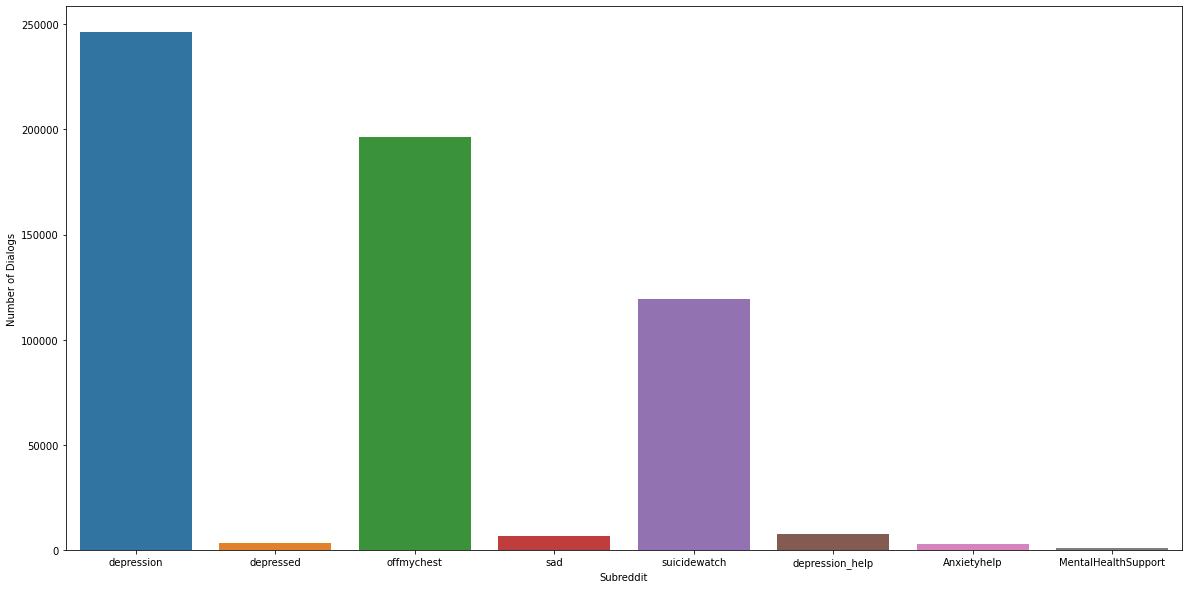

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_diags_clean)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_diags_toxic = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_multi_convs_toxic['conversation id'].unique()), 
                                                        len(depressed_multi_convs_toxic['conversation id'].unique()), 
                                                        len(offmychest_multi_convs_toxic['conversation id'].unique()), 
                                                        len(sad_multi_convs_toxic['conversation id'].unique()), 
                                                        len(suicidewatch_multi_convs_toxic['conversation id'].unique()), 
                                                        len(depression_help_multi_convs_toxic['conversation id'].unique()), 
                                                        len(anxietyhelp_multi_convs_toxic['conversation id'].unique()), 
                                                        len(mentalhealthsupport_multi_convs_toxic['conversation id'].unique())]
})
subreddits_multi_diags_toxic

,subreddit,length
0,depression,21063
1,depressed,226
2,offmychest,15539
3,sad,419
4,suicidewatch,14106
5,depression_help,360
6,Anxietyhelp,73
7,MentalHealthSupport,38


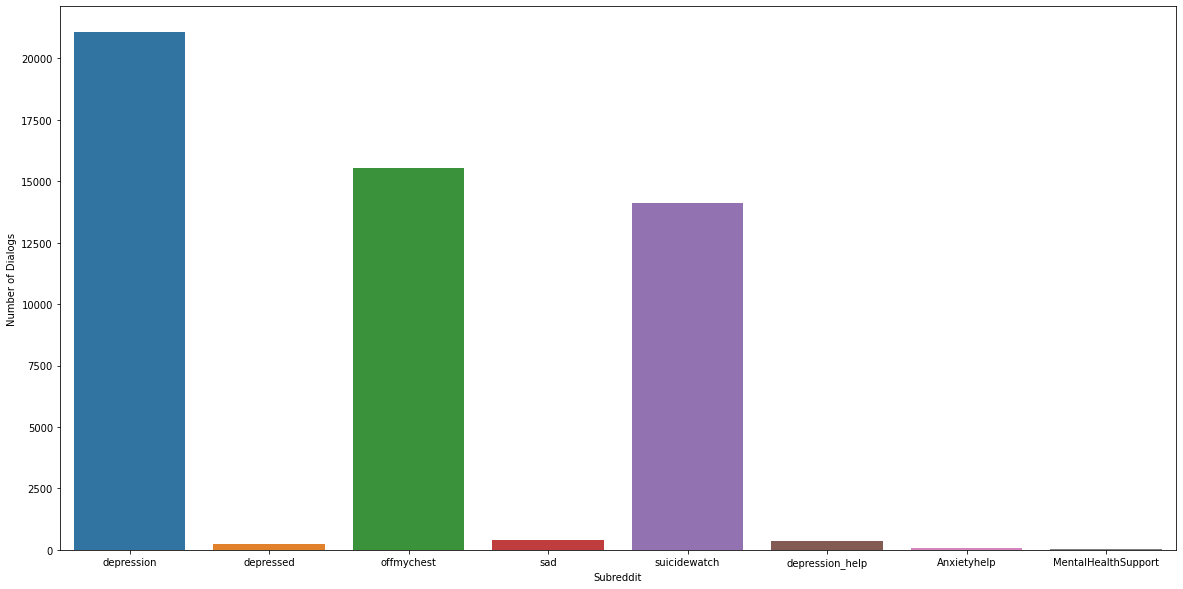

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_diags_toxic)
plt.xlabel('Subreddit')
plt.ylabel('Number of Dialogs')
plt.show()

<a name="process-multi-recompute-turn-clean-toxic"></a>
### Recompute Total Number of Turns in Clean and Toxic Conversation Datasets

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_turns_clean = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_multi_convs_clean), 
                                                        len(depressed_multi_convs_clean), 
                                                        len(offmychest_multi_convs_clean), 
                                                        len(sad_multi_convs_clean), 
                                                        len(suicidewatch_multi_convs_clean), 
                                                        len(depression_help_multi_convs_clean), 
                                                        len(anxietyhelp_multi_convs_clean), 
                                                        len(mentalhealthsupport_multi_convs_clean)]
})

subreddits_multi_turns_clean

,subreddit,length
0,depression,1609795
1,depressed,18658
2,offmychest,1232645
3,sad,35085
4,suicidewatch,899460
5,depression_help,45446
6,Anxietyhelp,16959
7,MentalHealthSupport,5793


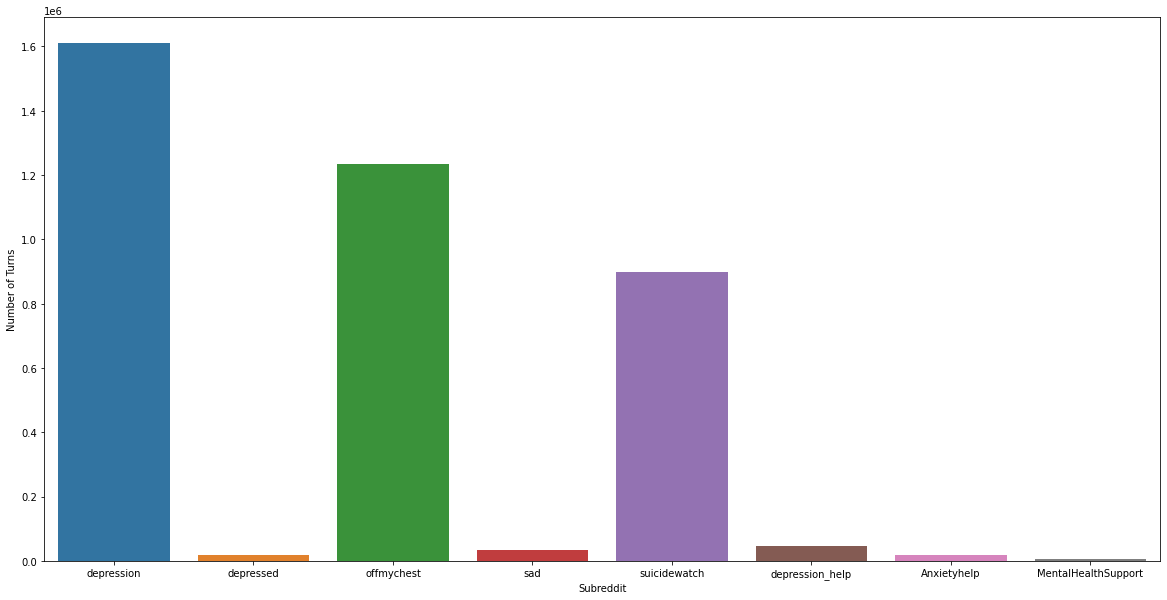

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_turns_clean)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

In [ ]:
# build a dataframe containing one column for subreddits and the other column for counting
subreddits_multi_turns_toxic = pd.DataFrame({'subreddit': ['depression', 'depressed', 'offmychest', 'sad', 'suicidewatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport'],\
                                              'length': [len(depression_multi_convs_toxic), 
                                                        len(depressed_multi_convs_toxic), 
                                                        len(offmychest_multi_convs_toxic), 
                                                        len(sad_multi_convs_toxic), 
                                                        len(suicidewatch_multi_convs_toxic), 
                                                        len(depression_help_multi_convs_toxic), 
                                                        len(anxietyhelp_multi_convs_toxic), 
                                                        len(mentalhealthsupport_multi_convs_toxic)]
})

subreddits_multi_turns_toxic

,subreddit,length
0,depression,28289
1,depressed,275
2,offmychest,24049
3,sad,526
4,suicidewatch,19393
5,depression_help,441
6,Anxietyhelp,82
7,MentalHealthSupport,44


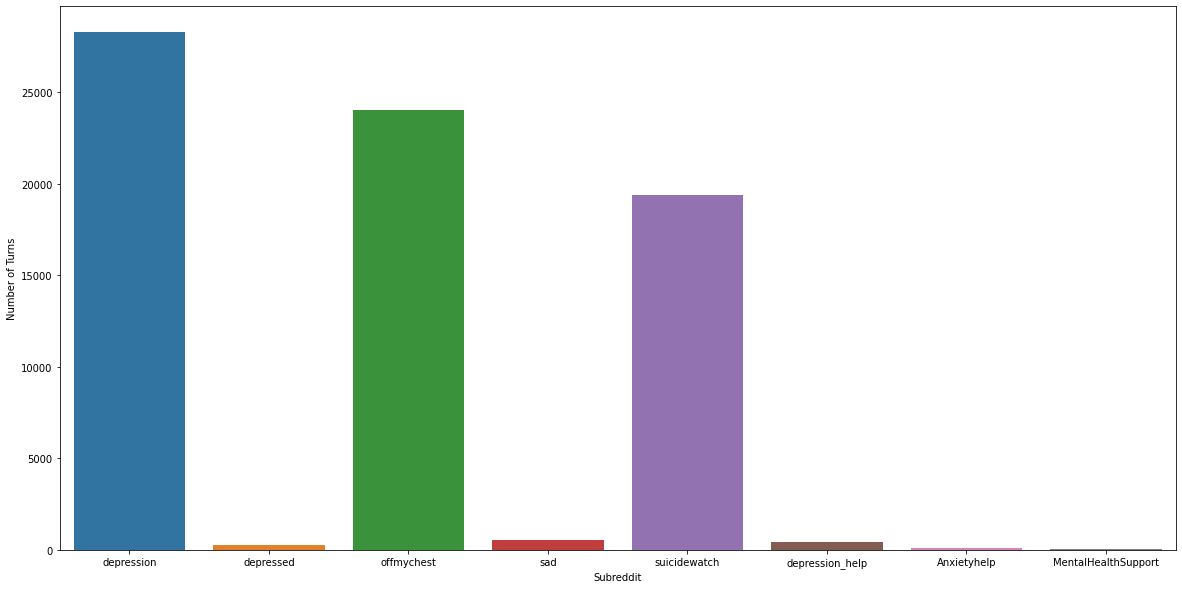

In [ ]:
# plot
plt.figure(figsize = (20, 10))
sns.barplot(x = 'subreddit', y = 'length', data = subreddits_multi_turns_toxic)
plt.xlabel('Subreddit')
plt.ylabel('Number of Turns')
plt.show()

<a name="process-multi-frequent-word"></a>
### Frequent Words on Both Speaker and Listener on Cleaner Datasets

In [ ]:
# load cleaner dataframe
sad_multi_convs_clean = pd.read_csv('sad_multi_convs_clean.csv', lineterminator='\n')
depression_multi_convs_clean = pd.read_csv('depression_multi_convs_clean.csv', lineterminator='\n')
depressed_multi_convs_clean = pd.read_csv('depressed_multi_convs_clean.csv', lineterminator='\n')
offmychest_multi_convs_clean = pd.read_csv('offmychest_multi_convs_clean.csv', lineterminator='\n')
suicidewatch_multi_convs_clean = pd.read_csv('suicidewatch_multi_convs_clean.csv', lineterminator='\n')
depression_help_multi_convs_clean = pd.read_csv('depression_help_multi_convs_clean.csv', lineterminator='\n')
anxietyhelp_multi_convs_clean = pd.read_csv('anxietyhelp_multi_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_multi_convs_clean = pd.read_csv('mentalhealthsupport_multi_convs_clean.csv', lineterminator='\n')

In [ ]:
# save the ranking dataframe
find_speaker_frequent_words(sad_multi_convs_clean, 20).to_csv('sad_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(sad_multi_convs_clean, 20).to_csv('sad_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depression_multi_convs_clean, 20).to_csv('depression_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depression_multi_convs_clean, 20).to_csv('depression_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(offmychest_multi_convs_clean, 20).to_csv('offmychest_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(offmychest_multi_convs_clean, 20).to_csv('offmychest_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(suicidewatch_multi_convs_clean, 20).to_csv('suicidewatch_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(suicidewatch_multi_convs_clean, 20).to_csv('suicidewatch_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depression_help_multi_convs_clean, 20).to_csv('depression_help_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depression_help_multi_convs_clean, 20).to_csv('depression_help_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(anxietyhelp_multi_convs_clean, 20).to_csv('anxietyhelp_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(anxietyhelp_multi_convs_clean, 20).to_csv('anxietyhelp_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(depressed_multi_convs_clean, 20).to_csv('depressed_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(depressed_multi_convs_clean, 20).to_csv('depressed_multi_listener_top20_freq_words.csv', index = False)
find_speaker_frequent_words(mentalhealthsupport_multi_convs_clean, 20).to_csv('mentalhealthsupport_multi_speaker_top20_freq_words.csv', index = False)
find_listener_frequent_words(mentalhealthsupport_multi_convs_clean, 20).to_csv('mentalhealthsupport_multi_listener_top20_freq_words.csv', index = False)

### Profanity Count on Speakers and Listeners

In [ ]:
# speaker profanity count
print(count_speaker_profanity(sad_multi_convs_concise))
print(count_speaker_profanity(depression_multi_convs_concise))
print(count_speaker_profanity(offmychest_multi_convs_concise))
print(count_speaker_profanity(suicidewatch_multi_convs_concise))
print(count_speaker_profanity(depression_help_multi_convs_concise))
print(count_speaker_profanity(depressed_multi_convs_concise))
print(count_speaker_profanity(anxietyhelp_multi_convs_concise))
print(count_speaker_profanity(mentalhealthsupport_multi_convs_concise))

737
32580
37124
25186
651
519
83
85


In [ ]:
# listener profanity count
print(count_listener_profanity(sad_multi_convs_concise))
print(count_listener_profanity(depression_multi_convs_concise))
print(count_listener_profanity(offmychest_multi_convs_concise))
print(count_listener_profanity(suicidewatch_multi_convs_concise))
print(count_listener_profanity(depression_help_multi_convs_concise))
print(count_listener_profanity(depressed_multi_convs_concise))
print(count_listener_profanity(anxietyhelp_multi_convs_concise))
print(count_listener_profanity(mentalhealthsupport_multi_convs_concise))

526
28289
24049
19393
441
275
82
44


<a name="process-multi-lang-correct"></a>
### Language Correct

In [ ]:
# load dataframe
sad_multi_convs_clean = pd.read_csv('sad_multi_convs_clean.csv', lineterminator='\n')
depression_multi_convs_clean = pd.read_csv('depression_multi_convs_clean.csv', lineterminator='\n')
depressed_multi_convs_clean = pd.read_csv('depressed_multi_convs_clean.csv', lineterminator='\n')
offmychest_multi_convs_clean = pd.read_csv('offmychest_multi_convs_clean.csv', lineterminator='\n')
suicidewatch_multi_convs_clean = pd.read_csv('suicidewatch_multi_convs_clean.csv', lineterminator='\n')
depression_help_multi_convs_clean = pd.read_csv('depression_help_multi_convs_clean.csv', lineterminator='\n')
anxietyhelp_multi_convs_clean = pd.read_csv('anxietyhelp_multi_convs_clean.csv', lineterminator='\n')
mentalhealthsupport_multi_convs_clean = pd.read_csv('mentalhealthsupport_multi_convs_clean.csv', lineterminator='\n')

In [ ]:
# language correct
sad_multi_convs_clean_corrected = lang_correct(sad_multi_convs_clean, tool)
depression_multi_convs_clean_corrected = lang_correct(depression_multi_convs_clean, tool)
depressed_multi_convs_clean_corrected = lang_correct(depressed_multi_convs_clean, tool)
offmychest_multi_convs_clean_corrected = lang_correct(offmychest_multi_convs_clean, tool)
suicidewatch_multi_convs_clean_corrected = lang_correct(suicidewatch_multi_convs_clean, tool)
depression_help_multi_convs_clean_corrected = lang_correct(depression_help_multi_convs_clean, tool)
anxietyhelp_multi_convs_clean_corrected = lang_correct(anxietyhelp_multi_convs_clean, tool)
mentalhealthsupport_multi_convs_clean_corrected = lang_correct(mentalhealthsupport_multi_convs_clean, tool)

In [ ]:
# save
sad_multi_convs_clean_corrected.to_csv('sad_multi_convs_clean_corrected.csv', index = False)
depression_multi_convs_clean_corrected.to_csv('depression_multi_convs_clean_corrected.csv', index = False)
depressed_multi_convs_clean_corrected.to_csv('depressed_multi_convs_clean_corrected.csv', index = False)
offmychest_multi_convs_clean_corrected.to_csv('offmychest_multi_convs_clean_corrected.csv', index = False)
suicidewatch_multi_convs_clean_corrected.to_csv('suicidewatch_multi_convs_clean_corrected.csv', index = False)
depression_help_multi_convs_clean_corrected.to_csv('depression_help_multi_convs_clean_corrected.csv', index = False)
anxietyhelp_multi_convs_clean_corrected.to_csv('anxietyhelp_multi_convs_clean_corrected.csv', index = False)
mentalhealthsupport_multi_convs_clean_corrected.to_csv('mentalhealthsupport_multi_convs_clean_corrected.csv', index = False)

<a name="process-multi-sentiment"></a>
### Sentiment Analysis

In [ ]:
# add sentiment to the original dataframe
sad_multi_convs_clean = compute_sentiment(sad_multi_convs_clean)
depression_multi_convs_clean = compute_sentiment(depression_multi_convs_clean)
depressed_multi_convs_clean = compute_sentiment(depressed_multi_convs_clean)
offmychest_multi_convs_clean = compute_sentiment(offmychest_multi_convs_clean)
suicidewatch_multi_convs_clean = compute_sentiment(suicidewatch_multi_convs_clean)
depression_help_multi_convs_clean = compute_sentiment(depression_help_multi_convs_clean)
anxietyhelp_multi_convs_clean = compute_sentiment(anxietyhelp_multi_convs_clean)
mentalhealthsupport_multi_convs_clean = compute_sentiment(mentalhealthsupport_multi_convs_clean)

In [ ]:
# save
sad_multi_convs_clean.to_csv('sad_multi_convs_clean_sentiment.csv', index = False)
depression_multi_convs_clean.to_csv('depression_multi_convs_clean_sentiment.csv', index = False)
depressed_multi_convs_clean.to_csv('depressed_multi_convs_clean_sentiment.csv', index = False)
offmychest_multi_convs_clean.to_csv('offmychest_multi_convs_clean_sentiment.csv', index = False)
suicidewatch_multi_convs_clean.to_csv('suicidewatch_multi_convs_clean_sentiment.csv', index = False)
depression_help_multi_convs_clean.to_csv('depression_help_multi_convs_clean_sentiment.csv', index = False)
anxietyhelp_multi_convs_clean.to_csv('anxietyhelp_multi_convs_clean_sentiment.csv', index = False)
mentalhealthsupport_multi_convs_clean.to_csv('mentalhealthsupport_multi_convs_clean_sentiment.csv', index = False)

In [ ]:
# compute sentiment count from speaker and listener
total_speaker_sentiment_multi_convs = speaker_sentiment_count(sad_multi_convs_clean)\
                                        + speaker_sentiment_count(depression_multi_convs_clean)\
                                        + speaker_sentiment_count(depressed_multi_convs_clean)\
                                        + speaker_sentiment_count(offmychest_multi_convs_clean)\
                                        + speaker_sentiment_count(suicidewatch_multi_convs_clean)\
                                        + speaker_sentiment_count(depression_help_multi_convs_clean)\
                                        + speaker_sentiment_count(anxietyhelp_multi_convs_clean)\
                                        + speaker_sentiment_count(mentalhealthsupport_multi_convs_clean)

total_listener_sentiment_multi_convs = listener_sentiment_count(sad_multi_convs_clean)\
                                        + listener_sentiment_count(depression_multi_convs_clean)\
                                        + listener_sentiment_count(depressed_multi_convs_clean)\
                                        + listener_sentiment_count(offmychest_multi_convs_clean)\
                                        + listener_sentiment_count(suicidewatch_multi_convs_clean)\
                                        + listener_sentiment_count(depression_help_multi_convs_clean)\
                                        + listener_sentiment_count(anxietyhelp_multi_convs_clean)\
                                        + listener_sentiment_count(mentalhealthsupport_multi_convs_clean)

<Figure size 1440x720 with 0 Axes>

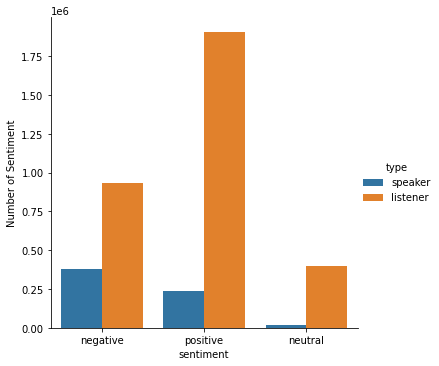

In [ ]:
# transform to dataframe
total_speaker_sentiment_multi_convs_df = pd.DataFrame(total_speaker_sentiment_multi_convs)\
                                            .reset_index().rename(columns = {'index': 'sentiment', 'sentiment': 'count'})

total_listener_sentiment_multi_convs_df = pd.DataFrame(total_listener_sentiment_multi_convs)\
                                            .reset_index().rename(columns = {'index': 'sentiment', 'sentiment': 'count'})

# add type
total_speaker_sentiment_multi_convs_df['type'] = 'speaker'
total_listener_sentiment_multi_convs_df['type'] = 'listener'

# combine both 
total_sentiment_multi_convs_df = pd.concat([total_speaker_sentiment_multi_convs_df, 
                                            total_listener_sentiment_multi_convs_df])\
                                            .reset_index().drop('index', axis = 1)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'sentiment', y = 'count', hue = 'type', data = total_sentiment_multi_convs_df, kind = 'bar')
plt.ylabel('Number of Sentiment')
plt.show()

<a name="process-whole"></a>
## Consider **Whole** Data

<a name="process-whole-dialog"></a>
### Total Number of Dyadic and Multiparty Conversations in Each Subreddit

<Figure size 1440x720 with 0 Axes>

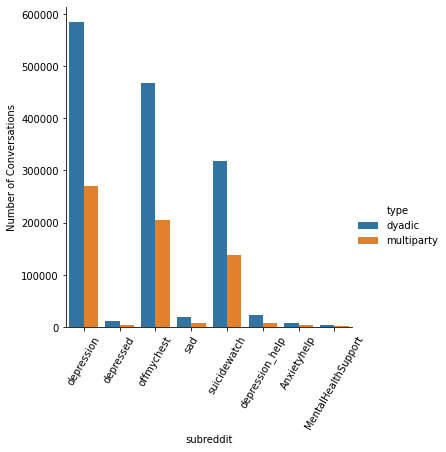

In [ ]:
# add type
subreddits_dyadic_diags['type'] = 'dyadic'
subreddits_multi_diags['type'] = 'multiparty'

# combine both 
subreddits_diags = pd.concat([subreddits_dyadic_diags, subreddits_multi_diags]).reset_index().drop('index', axis = 1)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'subreddit', y = 'length', hue = 'type', data = subreddits_diags, kind = 'bar')
plt.ylabel('Number of Conversations')
plt.xticks(rotation = 60)
plt.show()

<a name="process-whole-turn"></a>
### Total Number of Dyadic and Multiparty Conversation **Turns** in Each Subreddit

<Figure size 1440x720 with 0 Axes>

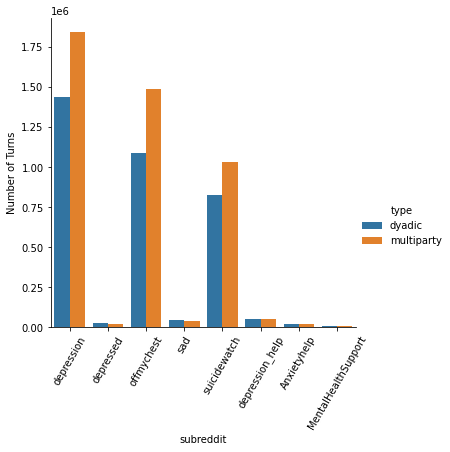

In [ ]:
# add type
subreddits_dyadic_turns['type'] = 'dyadic'
subreddits_multi_turns['type'] = 'multiparty'

# combine both 
subreddits_turns = pd.concat([subreddits_dyadic_turns, subreddits_multi_turns]).reset_index().drop('index', axis = 1)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'subreddit', y = 'length', hue = 'type', data = subreddits_turns, kind = 'bar')
plt.ylabel('Number of Turns')
plt.xticks(rotation = 60)
plt.show()

<a name="process-whole-distribution"></a>
### Turn Distribution between Dyadic and Multiparty Conversations

In [ ]:
# sum up based on their count
subreddits_dyadic_convs_turn_dist = pd.concat([sad_dyadic_convs_turn_dist,
                                               depression_dyadic_convs_turn_dist,
                                               depressed_dyadic_convs_turn_dist,
                                               offmychest_dyadic_convs_turn_dist,
                                               suicidewatch_dyadic_convs_turn_dist,
                                               depression_help_dyadic_convs_turn_dist,
                                               anxietyhelp_dyadic_convs_turn_dist,
                                               mentalhealthsupport_dyadic_convs_turn_dist])\
                                      .groupby('turns').sum()

subreddits_multi_convs_turn_dist = pd.concat([sad_multi_convs_turn_dist,
                                               depression_multi_convs_turn_dist,
                                               depressed_multi_convs_turn_dist,
                                               offmychest_multi_convs_turn_dist,
                                               suicidewatch_multi_convs_turn_dist,
                                               depression_help_multi_convs_turn_dist,
                                               anxietyhelp_multi_convs_turn_dist,
                                               mentalhealthsupport_multi_convs_turn_dist])\
                                      .groupby('turns').sum()

# combine both
subreddits_dyadic_convs_turn_dist['type'] = 'dyadic'
subreddits_multi_convs_turn_dist['type'] = 'multiparty'
subreddits_turn_dist = pd.concat([subreddits_dyadic_convs_turn_dist, subreddits_multi_convs_turn_dist])\
                            .reset_index()\
                            .sort_values(by = ['turns'])

,turns,count,type
0,2,925539,dyadic
93,3,157792,multiparty
1,3,113976,dyadic
2,4,124991,dyadic
94,4,116971,multiparty
3,5,36976,dyadic
95,5,64871,multiparty
4,6,30529,dyadic
96,6,51575,multiparty
5,7,13170,dyadic


<Figure size 1440x720 with 0 Axes>

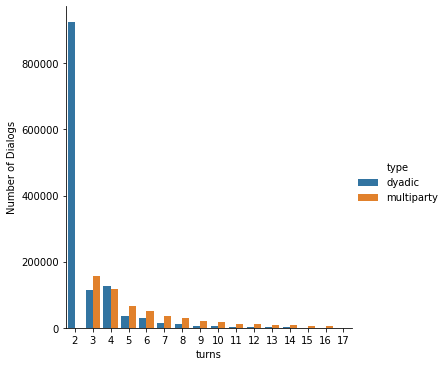

In [ ]:
display(subreddits_turn_dist[:30])

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'turns', y = 'count', hue = 'type', data = subreddits_turn_dist[:30], kind = 'bar')
plt.ylabel('Number of Dialogs')
plt.show()

In [ ]:
column_list = ['subreddit', 'count']
subreddit_list = ['depression', 'depressed', 'offmychest', 'sad', 'SuicideWatch', 'depression_help', 'Anxietyhelp', 'MentalHealthSupport']
count_list = [70526, 1491, 78700, 1792, 58986, 1883, 197, 222]
value_list = list(zip(subreddit_list, count_list))

profanity_dyadic_speaker_df = pd.DataFrame(value_list, columns = column_list)

In [ ]:
count_list = [18855, 316, 13168, 497, 12652, 357, 64, 34]
value_list = list(zip(subreddit_list, count_list))

profanity_dyadic_listener_df = pd.DataFrame(value_list, columns = column_list)

In [ ]:
count_list = [32580, 519, 37124, 737, 25186, 651, 83, 85]
value_list = list(zip(subreddit_list, count_list))

profanity_multi_speaker_df = pd.DataFrame(value_list, columns = column_list)

In [ ]:
count_list = [28289, 275, 24049, 526, 19393, 441, 82, 44]
value_list = list(zip(subreddit_list, count_list))

profanity_multi_listener_df = pd.DataFrame(value_list, columns = column_list)

In [ ]:
profanity_dyadic_speaker_df['type'] = 'speaker'
profanity_dyadic_listener_df['type'] = 'listener'
profanity_multi_speaker_df['type'] = 'speaker'
profanity_multi_listener_df['type'] = 'listener'

,subreddit,count,type
0,depression,70526,speaker
1,depressed,1491,speaker
2,offmychest,78700,speaker
3,sad,1792,speaker
4,SuicideWatch,58986,speaker
5,depression_help,1883,speaker
6,Anxietyhelp,197,speaker
7,MentalHealthSupport,222,speaker
8,depression,18855,listener
9,depressed,316,listener


<Figure size 1440x720 with 0 Axes>

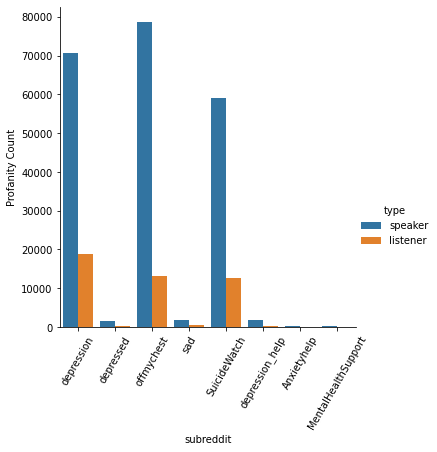

In [ ]:
# combine both 
profanity_dyadic_df = pd.concat([profanity_dyadic_speaker_df, profanity_dyadic_listener_df]).reset_index().drop('index', axis = 1)
display(profanity_dyadic_df)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'subreddit', y = 'count', hue = 'type', data = profanity_dyadic_df, kind = 'bar')
plt.ylabel('Profanity Count')
plt.xticks(rotation = 60)
plt.show()

In [ ]:
# combine both 
profanity_dyadic_df = pd.concat([profanity_multi_speaker_df, profanity_multi_listener_df]).reset_index().drop('index', axis = 1)
display(profanity_dyadic_df)

# paired barplot
plt.figure(figsize = (20, 10))
sns.catplot(x = 'subreddit', y = 'count', hue = 'type', data = profanity_dyadic_df, kind = 'bar')
plt.ylabel('Profanity Count')
plt.xticks(rotation = 60)
plt.show()

<a name="process-whole-emotion"></a>
### Emotion Prediction

In [ ]:
# load data (dyadic)
sad_dyadic_convs_clean_emotion = pd.read_csv('sad_dyadic_convs_clean_emotion.csv', lineterminator='\n')
depression_dyadic_convs_clean_emotion = pd.read_csv('depression_dyadic_convs_clean_emotion.csv')
depressed_dyadic_convs_clean_emotion = pd.read_csv('depressed_dyadic_convs_clean_emotion.csv')
offmychest_dyadic_convs_clean_emotion = pd.read_csv('offmychest_dyadic_convs_clean_emotion.csv')
suicidewatch_dyadic_convs_clean_emotion = pd.read_csv('suicidewatch_dyadic_convs_clean_emotion.csv', lineterminator='\n')
depression_help_dyadic_convs_clean_emotion = pd.read_csv('depression_help_dyadic_convs_clean_emotion.csv')
anxietyhelp_dyadic_convs_clean_emotion = pd.read_csv('anxietyhelp_dyadic_convs_clean_emotion.csv')
mentalhealthsupport_dyadic_convs_clean_emotion = pd.read_csv('mentalhealthsupport_dyadic_convs_clean_emotion.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# remove non-numeric conversation ID
sad_dyadic_convs_clean_emotion = remove_nonnumeric_id(sad_dyadic_convs_clean_emotion)
depression_dyadic_convs_clean_emotion = remove_nonnumeric_id(depression_dyadic_convs_clean_emotion)
offmychest_dyadic_convs_clean_emotion = remove_nonnumeric_id(offmychest_dyadic_convs_clean_emotion)
suicidewatch_dyadic_convs_clean_emotion = remove_nonnumeric_id(suicidewatch_dyadic_convs_clean_emotion)
depressed_dyadic_convs_clean_emotion = remove_nonnumeric_id(depressed_dyadic_convs_clean_emotion)
depression_help_dyadic_convs_clean_emotion = remove_nonnumeric_id(depression_help_dyadic_convs_clean_emotion)
anxietyhelp_dyadic_convs_clean_emotion = remove_nonnumeric_id(anxietyhelp_dyadic_convs_clean_emotion)
mentalhealthsupport_dyadic_convs_clean_emotion = remove_nonnumeric_id(mentalhealthsupport_dyadic_convs_clean_emotion)

In [ ]:
# load data (multiparty)
sad_multi_convs_clean_emotion = pd.read_csv('sad_multi_convs_clean_emotion.csv', lineterminator='\n')
depression_multi_convs_clean_emotion = pd.read_csv('depression_multi_convs_clean_emotion.csv')
depressed_multi_convs_clean_emotion = pd.read_csv('depressed_multi_convs_clean_emotion.csv')
offmychest_multi_convs_clean_emotion = pd.read_csv('offmychest_multi_convs_clean_emotion.csv')
suicidewatch_multi_convs_clean_emotion = pd.read_csv('suicidewatch_multi_convs_clean_emotion.csv')
depression_help_multi_convs_clean_emotion = pd.read_csv('depression_help_multi_convs_clean_emotion.csv')
anxietyhelp_multi_convs_clean_emotion = pd.read_csv('anxietyhelp_multi_convs_clean_emotion.csv')
mentalhealthsupport_multi_convs_clean_emotion = pd.read_csv('mentalhealthsupport_multi_convs_clean_emotion.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# summarize the emotion counting for each subreddit (speaker)
sad_dyadic_speaker_emotion_count = build_speaker_emotion_count(sad_dyadic_convs_clean_emotion)
sad_dyadic_speaker_emotion_count.to_csv('sad_dyadic_speaker_emotion_count.csv')
depression_dyadic_speaker_emotion_count = build_speaker_emotion_count(depression_dyadic_convs_clean_emotion)
depression_dyadic_speaker_emotion_count.to_csv('depression_dyadic_speaker_emotion_count.csv')
depressed_dyadic_speaker_emotion_count = build_speaker_emotion_count(depressed_dyadic_convs_clean_emotion)
depressed_dyadic_speaker_emotion_count.to_csv('depressed_dyadic_speaker_emotion_count.csv')
offmychest_dyadic_speaker_emotion_count = build_speaker_emotion_count(offmychest_dyadic_convs_clean_emotion)
offmychest_dyadic_speaker_emotion_count.to_csv('offmychest_dyadic_speaker_emotion_count.csv')
suicidewatch_dyadic_speaker_emotion_count = build_speaker_emotion_count(suicidewatch_dyadic_convs_clean_emotion)
suicidewatch_dyadic_speaker_emotion_count.to_csv('suicidewatch_dyadic_speaker_emotion_count.csv')
depression_help_dyadic_speaker_emotion_count = build_speaker_emotion_count(depression_help_dyadic_convs_clean_emotion)
depression_help_dyadic_speaker_emotion_count.to_csv('depression_help_dyadic_speaker_emotion_count.csv')
anxietyhelp_dyadic_speaker_emotion_count = build_speaker_emotion_count(anxietyhelp_dyadic_convs_clean_emotion)
anxietyhelp_dyadic_speaker_emotion_count.to_csv('anxietyhelp_dyadic_speaker_emotion_count.csv')
mentalhealthsupport_dyadic_speaker_emotion_count = build_speaker_emotion_count(mentalhealthsupport_dyadic_convs_clean_emotion)
mentalhealthsupport_dyadic_speaker_emotion_count.to_csv('mentalhealthsupport_dyadic_speaker_emotion_count.csv')

In [ ]:
# summarize the emotion counting for each subreddit (listener)
sad_dyadic_listener_emotion_count = build_listener_emotion_count(sad_dyadic_convs_clean_emotion)
sad_dyadic_listener_emotion_count.to_csv('sad_dyadic_listener_emotion_count.csv')
depression_dyadic_listener_emotion_count = build_listener_emotion_count(depression_dyadic_convs_clean_emotion)
depression_dyadic_listener_emotion_count.to_csv('depression_dyadic_listener_emotion_count.csv')
depressed_dyadic_listener_emotion_count = build_listener_emotion_count(depressed_dyadic_convs_clean_emotion)
depressed_dyadic_listener_emotion_count.to_csv('depressed_dyadic_listener_emotion_count.csv')
offmychest_dyadic_listener_emotion_count = build_listener_emotion_count(offmychest_dyadic_convs_clean_emotion)
offmychest_dyadic_listener_emotion_count.to_csv('offmychest_dyadic_listener_emotion_count.csv')
suicidewatch_dyadic_listener_emotion_count = build_listener_emotion_count(suicidewatch_dyadic_convs_clean_emotion)
suicidewatch_dyadic_listener_emotion_count.to_csv('suicidewatch_dyadic_listener_emotion_count.csv')
depression_help_dyadic_listener_emotion_count = build_listener_emotion_count(depression_help_dyadic_convs_clean_emotion)
depression_help_dyadic_listener_emotion_count.to_csv('depression_help_dyadic_listener_emotion_count.csv')
anxietyhelp_dyadic_listener_emotion_count = build_listener_emotion_count(anxietyhelp_dyadic_convs_clean_emotion)
anxietyhelp_dyadic_listener_emotion_count.to_csv('anxietyhelp_dyadic_listener_emotion_count.csv')
mentalhealthsupport_dyadic_listener_emotion_count = build_listener_emotion_count(mentalhealthsupport_dyadic_convs_clean_emotion)
mentalhealthsupport_dyadic_listener_emotion_count.to_csv('mentalhealthsupport_dyadic_listener_emotion_count.csv')

In [ ]:
ED_emotions = ['afraid', 'angry','annoyed',
            'anticipating','anxious','apprehensive','ashamed','caring','confident','content','devastated','disappointed',
            'disgusted','embarrassed','excited','faithful','furious','grateful','guilty','hopeful','impressed','jealous',
            'joyful','lonely','nostalgic','prepared','proud','sad','sentimental','surprised','terrified','trusting',
            'agreeing','acknowledging','encouraging','consoling','sympathizing','suggesting','questioning','wishing','neutral']

def build_emotion_count(df):
    original = pd.Series(index = ED_emotions, dtype= 'float64').fillna(0)
    result = original + pd.Series(df['count'].values, index = df['emotion'])
    result = result.fillna(0)
    return result

In [ ]:
dyadic_speaker_emotion_count = build_emotion_count(sad_dyadic_speaker_emotion_count)\
                                + build_emotion_count(depression_dyadic_speaker_emotion_count)\
                                + build_emotion_count(depressed_dyadic_speaker_emotion_count)\
                                + build_emotion_count(offmychest_dyadic_speaker_emotion_count)\
                                + build_emotion_count(suicidewatch_dyadic_speaker_emotion_count)\
                                + build_emotion_count(depression_help_dyadic_speaker_emotion_count)\
                                + build_emotion_count(anxietyhelp_dyadic_speaker_emotion_count)\
                                + build_emotion_count(mentalhealthsupport_dyadic_speaker_emotion_count)

dyadic_listener_emotion_count = build_emotion_count(sad_dyadic_listener_emotion_count)\
                                + build_emotion_count(depression_dyadic_listener_emotion_count)\
                                + build_emotion_count(depressed_dyadic_listener_emotion_count)\
                                + build_emotion_count(offmychest_dyadic_listener_emotion_count)\
                                + build_emotion_count(suicidewatch_dyadic_listener_emotion_count)\
                                + build_emotion_count(depression_help_dyadic_listener_emotion_count)\
                                + build_emotion_count(anxietyhelp_dyadic_listener_emotion_count)\
                                + build_emotion_count(mentalhealthsupport_dyadic_listener_emotion_count)

In [ ]:
dyadic_speaker_emotion_count.to_csv('dyadic_speaker_emotion_count.csv')
dyadic_listener_emotion_count.to_csv('dyadic_listener_emotion_count.csv')

In [ ]:
multi_speaker_emotion_count = build_emotion_count(sad_multi_speaker_emotion_count)\
                                + build_emotion_count(depression_multi_speaker_emotion_count)\
                                + build_emotion_count(depressed_multi_speaker_emotion_count)\
                                + build_emotion_count(offmychest_multi_speaker_emotion_count)\
                                + build_emotion_count(suicidewatch_multi_speaker_emotion_count)\
                                + build_emotion_count(depression_help_multi_speaker_emotion_count)\
                                + build_emotion_count(anxietyhelp_multi_speaker_emotion_count)\
                                + build_emotion_count(mentalhealthsupport_multi_speaker_emotion_count)

multi_listener_emotion_count = build_emotion_count(sad_multi_listener_emotion_count)\
                                + build_emotion_count(depression_multi_listener_emotion_count)\
                                + build_emotion_count(depressed_multi_listener_emotion_count)\
                                + build_emotion_count(offmychest_multi_listener_emotion_count)\
                                + build_emotion_count(suicidewatch_multi_listener_emotion_count)\
                                + build_emotion_count(depression_help_multi_listener_emotion_count)\
                                + build_emotion_count(anxietyhelp_multi_listener_emotion_count)\
                                + build_emotion_count(mentalhealthsupport_multi_listener_emotion_count)

In [ ]:
multi_speaker_emotion_count.to_csv('multiparty_speaker_emotion_count.csv')
multi_listener_emotion_count.to_csv('multiparty_listener_emotion_count.csv')

In [ ]:
# load both dyadic and multiparty emotion count data
dyadic_speaker_emotion_count = pd.read_csv('dyadic_speaker_emotion_count.csv')
dyadic_listener_emotion_count = pd.read_csv('dyadic_listener_emotion_count.csv')
multi_speaker_emotion_count = pd.read_csv('multiparty_speaker_emotion_count.csv')
multi_listener_emotion_count = pd.read_csv('multiparty_listener_emotion_count.csv')

# change column names properly
dyadic_speaker_emotion_count = dyadic_speaker_emotion_count\
                                    .rename(columns = {'Unnamed: 0': 'emotion', '0': 'count'})

dyadic_listener_emotion_count = dyadic_listener_emotion_count\
                                    .rename(columns = {'Unnamed: 0': 'emotion', '0': 'count'})

multi_speaker_emotion_count = multi_speaker_emotion_count\
                                    .rename(columns = {'Unnamed: 0': 'emotion', '0': 'count'})

multi_listener_emotion_count = multi_listener_emotion_count\
                                    .rename(columns = {'Unnamed: 0': 'emotion', '0': 'count'})

In [ ]:
# add type
dyadic_speaker_emotion_count['type'] = 'dyadic'
dyadic_listener_emotion_count['type'] = 'dyadic'
multi_speaker_emotion_count['type'] = 'multiparty'
multi_listener_emotion_count['type'] = 'multiparty'

,emotion,count,type
0,acknowledging,24603.0,speaker
1,afraid,46944.0,speaker
2,agreeing,42118.0,speaker
3,angry,9493.0,speaker
4,annoyed,3689.0,speaker
...,...,...,...
77,surprised,21661.0,listener
78,sympathizing,18805.0,listener
79,terrified,18852.0,listener
80,trusting,44658.0,listener


,emotion,count,type
0,acknowledging,12212.0,speaker
1,afraid,63012.0,speaker
2,agreeing,38358.0,speaker
3,angry,20005.0,speaker
4,annoyed,14361.0,speaker
...,...,...,...
77,surprised,23843.0,listener
78,sympathizing,49555.0,listener
79,terrified,29919.0,listener
80,trusting,40411.0,listener


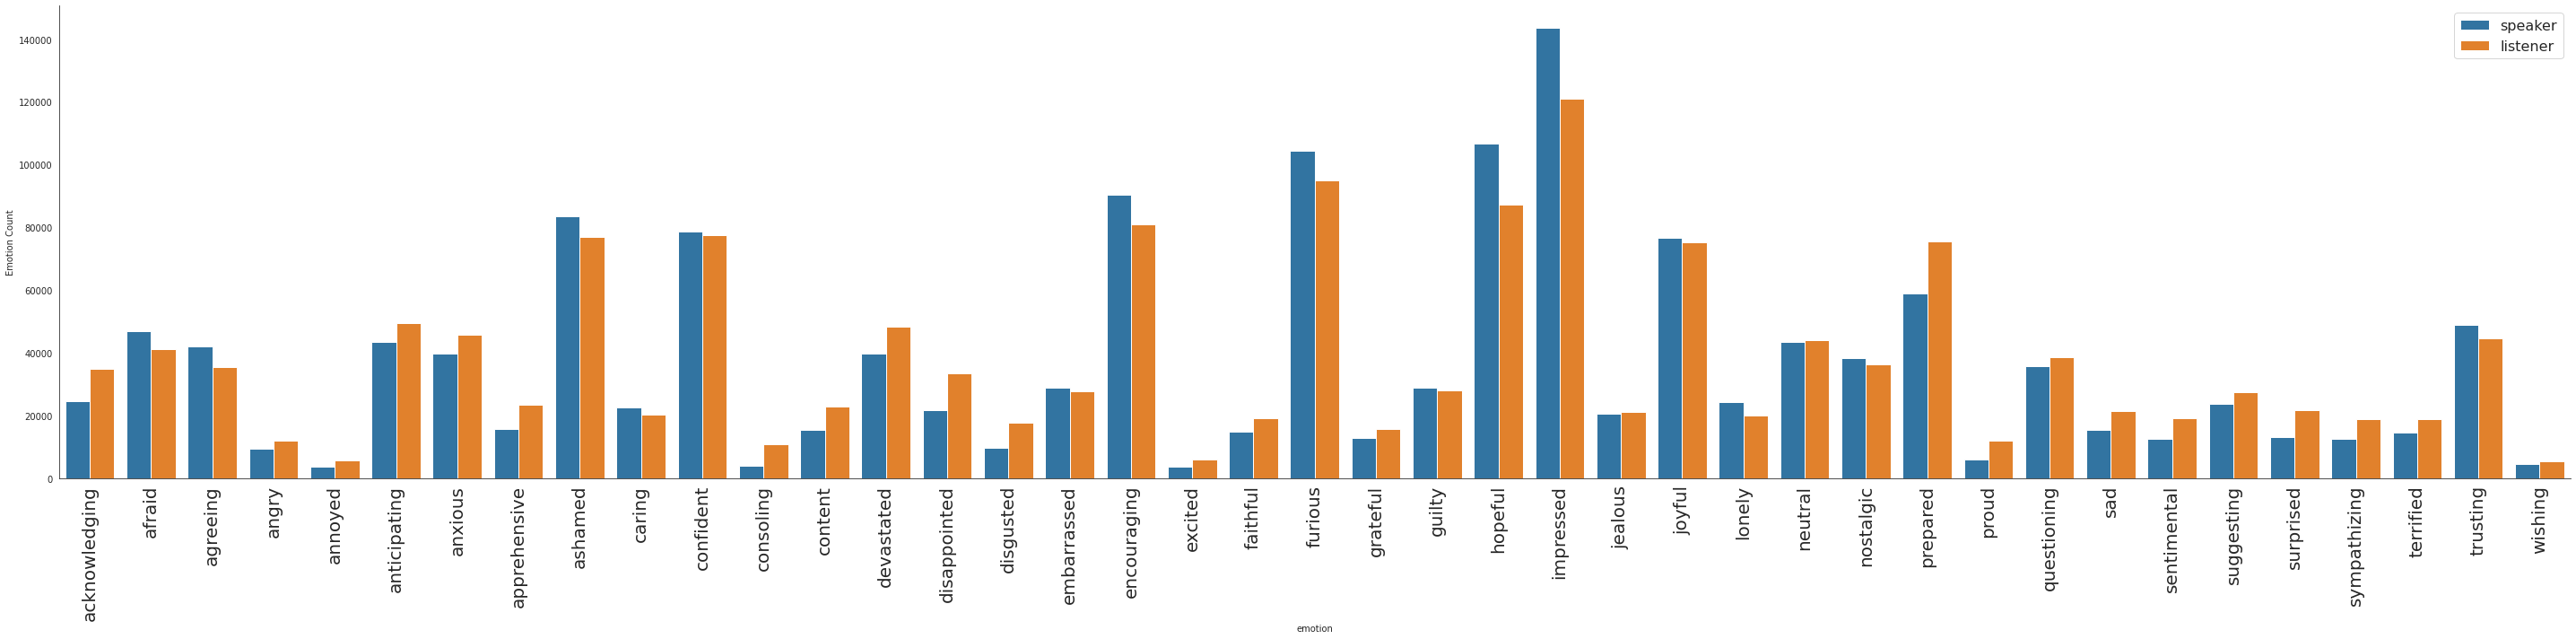

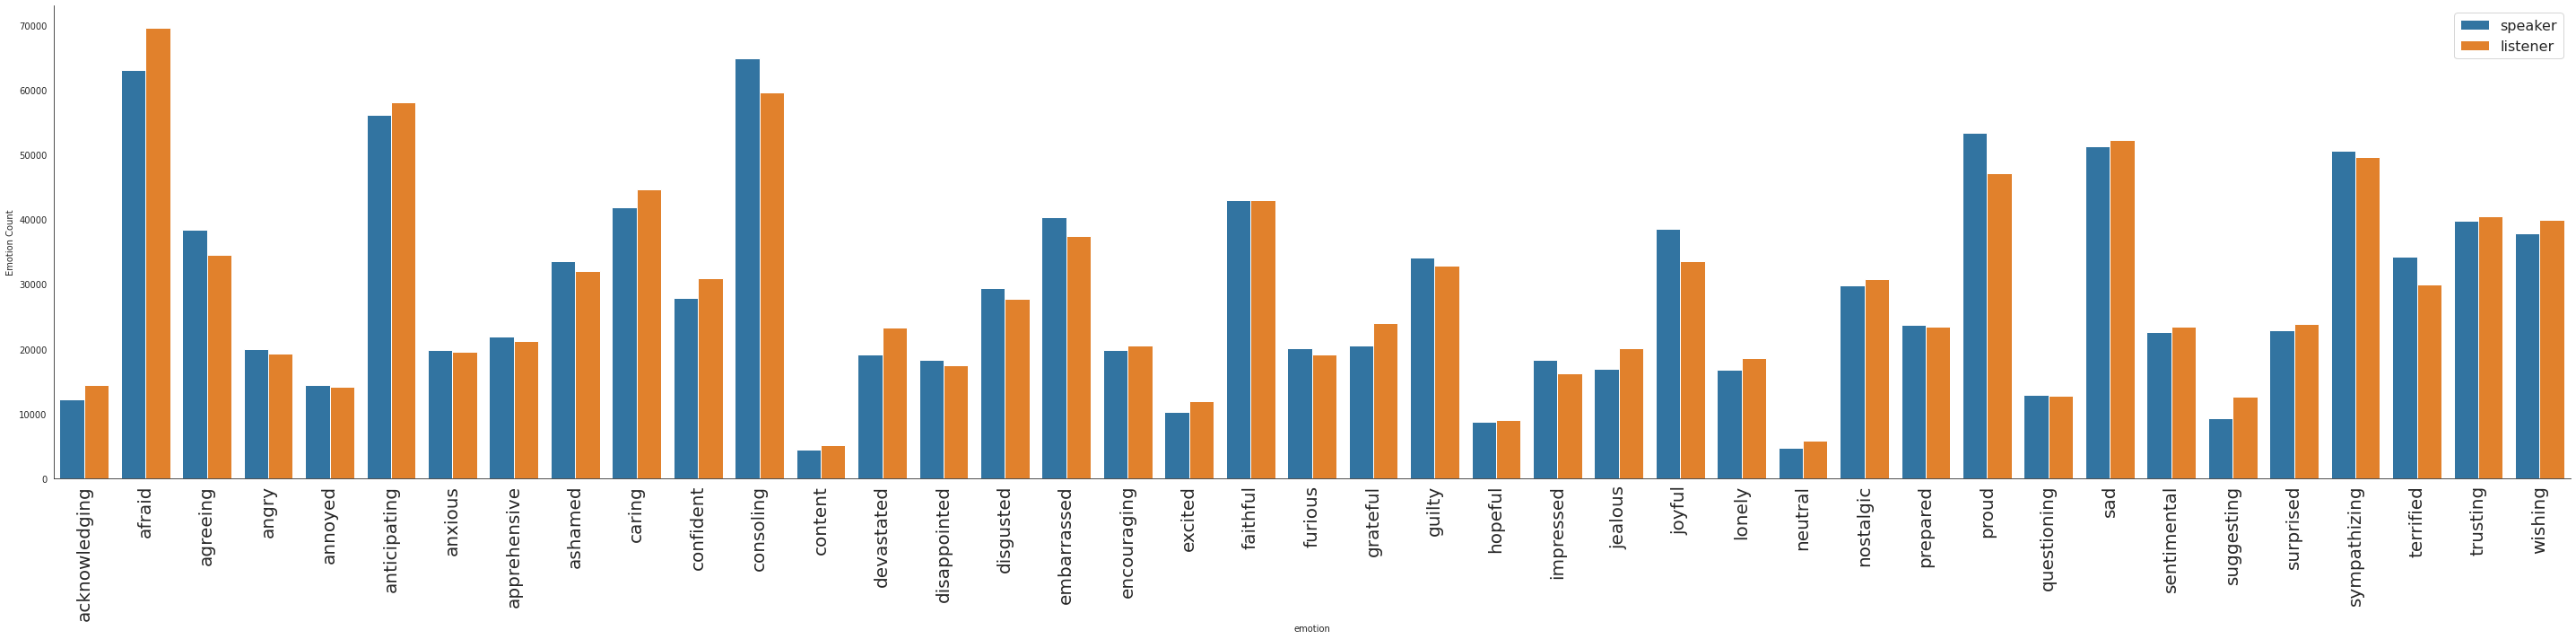

In [ ]:
# combine both 
dyadic_emotion_count = pd.concat([dyadic_speaker_emotion_count, dyadic_listener_emotion_count]).reset_index().drop('index', axis = 1)
display(dyadic_emotion_count)
multi_emotion_count = pd.concat([multi_speaker_emotion_count, multi_listener_emotion_count]).reset_index().drop('index', axis = 1)
display(multi_emotion_count)

# paired barplot
sns.set_style(style='white')
sns.catplot(x = 'emotion', y = 'count', hue = 'type',
            data = dyadic_emotion_count, kind = 'bar', height = 10, aspect = 40/10, legend = False)
plt.ylabel('Emotion Count')
plt.xticks(fontsize = 20, rotation = 90)
plt.tight_layout()
plt.legend(fontsize = 16, loc = 'upper right')
plt.savefig('dyadic emotion count.png')
plt.show()

# paired barplot
sns.set_style(style='white')
sns.catplot(x = 'emotion', y = 'count', hue = 'type',
            data = multi_emotion_count, kind = 'bar', height = 10, aspect = 40/10, legend = False)
plt.ylabel('Emotion Count')
plt.xticks(fontsize = 20, rotation = 90)
plt.tight_layout()
plt.legend(fontsize = 16, loc = 'upper right')
plt.savefig('multiparty emotion count.png')
plt.show()

In [ ]:
sad_dyadic_speaker_emotion_count = pd.read_csv('sad_dyadic_speaker_emotion_count.csv')
depression_dyadic_speaker_emotion_count = pd.read_csv('depression_dyadic_speaker_emotion_count.csv')
depressed_dyadic_speaker_emotion_count = pd.read_csv('depressed_dyadic_speaker_emotion_count.csv')
offmychest_dyadic_speaker_emotion_count = pd.read_csv('offmychest_dyadic_speaker_emotion_count.csv')
suicidewatch_dyadic_speaker_emotion_count = pd.read_csv('suicidewatch_dyadic_speaker_emotion_count.csv')
depression_help_dyadic_speaker_emotion_count = pd.read_csv('depression_help_dyadic_speaker_emotion_count.csv')
anxietyhelp_dyadic_speaker_emotion_count = pd.read_csv('anxietyhelp_dyadic_speaker_emotion_count.csv')
mentalhealthsupport_dyadic_speaker_emotion_count = pd.read_csv('mentalhealthsupport_dyadic_speaker_emotion_count.csv')

In [ ]:
sad_dyadic_listener_emotion_count = pd.read_csv('sad_dyadic_listener_emotion_count.csv')
depression_dyadic_listener_emotion_count = pd.read_csv('depression_dyadic_listener_emotion_count.csv')
depressed_dyadic_listener_emotion_count = pd.read_csv('depressed_dyadic_listener_emotion_count.csv')
offmychest_dyadic_listener_emotion_count = pd.read_csv('offmychest_dyadic_listener_emotion_count.csv')
suicidewatch_dyadic_listener_emotion_count = pd.read_csv('suicidewatch_dyadic_listener_emotion_count.csv')
depression_help_dyadic_listener_emotion_count = pd.read_csv('depression_help_dyadic_listener_emotion_count.csv')
anxietyhelp_dyadic_listener_emotion_count = pd.read_csv('anxietyhelp_dyadic_listener_emotion_count.csv')
mentalhealthsupport_dyadic_listener_emotion_count = pd.read_csv('mentalhealthsupport_dyadic_listener_emotion_count.csv')

In [ ]:
sad_multi_speaker_emotion_count = pd.read_csv('sad_multi_speaker_emotion_count.csv')
depression_multi_speaker_emotion_count = pd.read_csv('depression_multi_speaker_emotion_count.csv')
depressed_multi_speaker_emotion_count = pd.read_csv('depressed_multi_speaker_emotion_count.csv')
offmychest_multi_speaker_emotion_count = pd.read_csv('offmychest_multi_speaker_emotion_count.csv')
suicidewatch_multi_speaker_emotion_count = pd.read_csv('suicidewatch_multi_speaker_emotion_count.csv')
depression_help_multi_speaker_emotion_count = pd.read_csv('depression_help_multi_speaker_emotion_count.csv')
anxietyhelp_multi_speaker_emotion_count = pd.read_csv('anxietyhelp_multi_speaker_emotion_count.csv')
mentalhealthsupport_multi_speaker_emotion_count = pd.read_csv('mentalhealthsupport_multi_speaker_emotion_count.csv')

In [ ]:
sad_multi_listener_emotion_count = pd.read_csv('sad_multi_listener_emotion_count.csv')
depression_multi_listener_emotion_count = pd.read_csv('depression_multi_listener_emotion_count.csv')
depressed_multi_listener_emotion_count = pd.read_csv('depressed_multi_listener_emotion_count.csv')
offmychest_multi_listener_emotion_count = pd.read_csv('offmychest_multi_listener_emotion_count.csv')
suicidewatch_multi_listener_emotion_count = pd.read_csv('suicidewatch_multi_listener_emotion_count.csv')
depression_help_multi_listener_emotion_count = pd.read_csv('depression_help_multi_listener_emotion_count.csv')
anxietyhelp_multi_listener_emotion_count = pd.read_csv('anxietyhelp_multi_listener_emotion_count.csv')
mentalhealthsupport_multi_listener_emotion_count = pd.read_csv('mentalhealthsupport_multi_listener_emotion_count.csv')

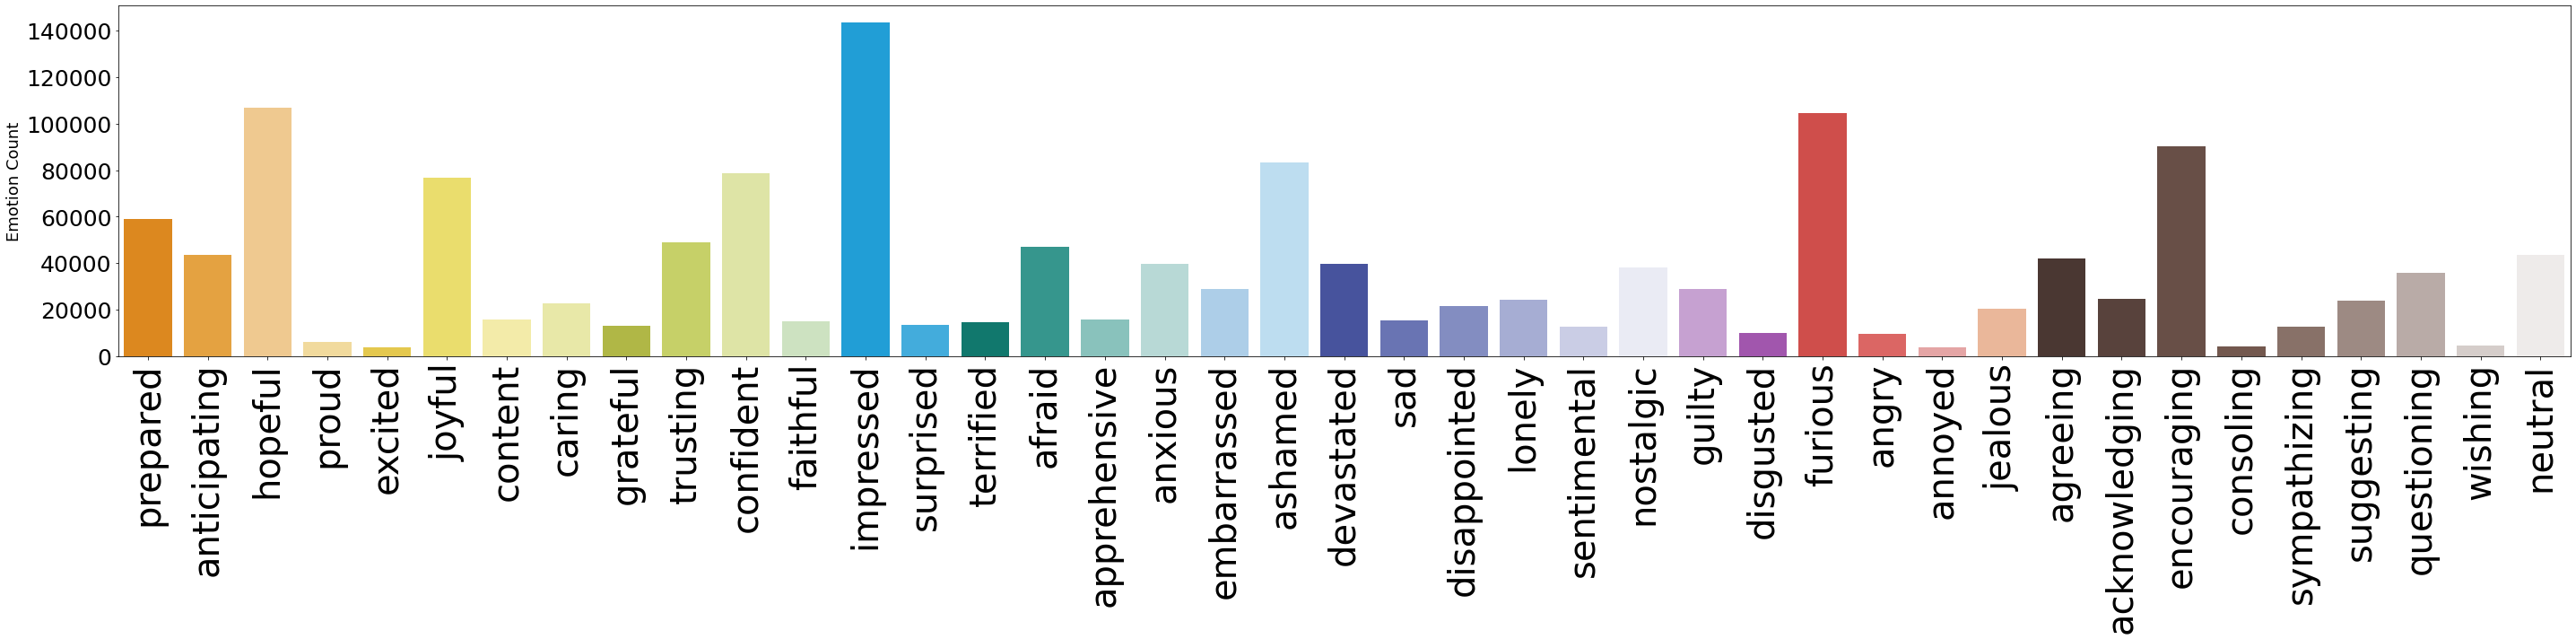

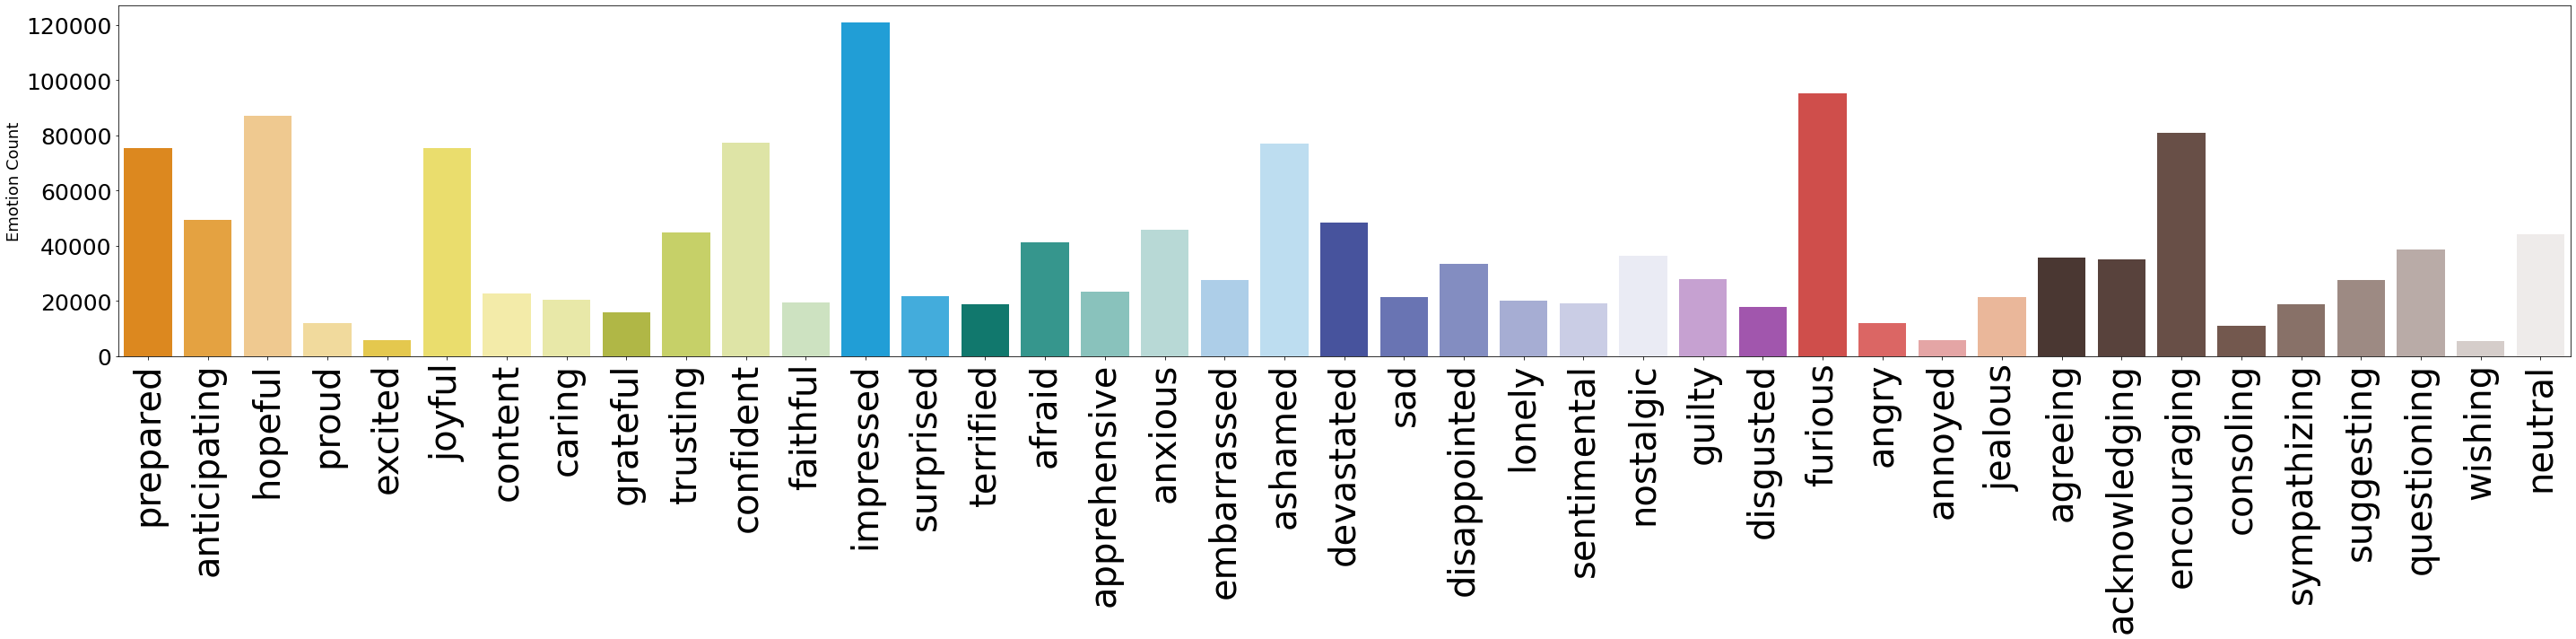

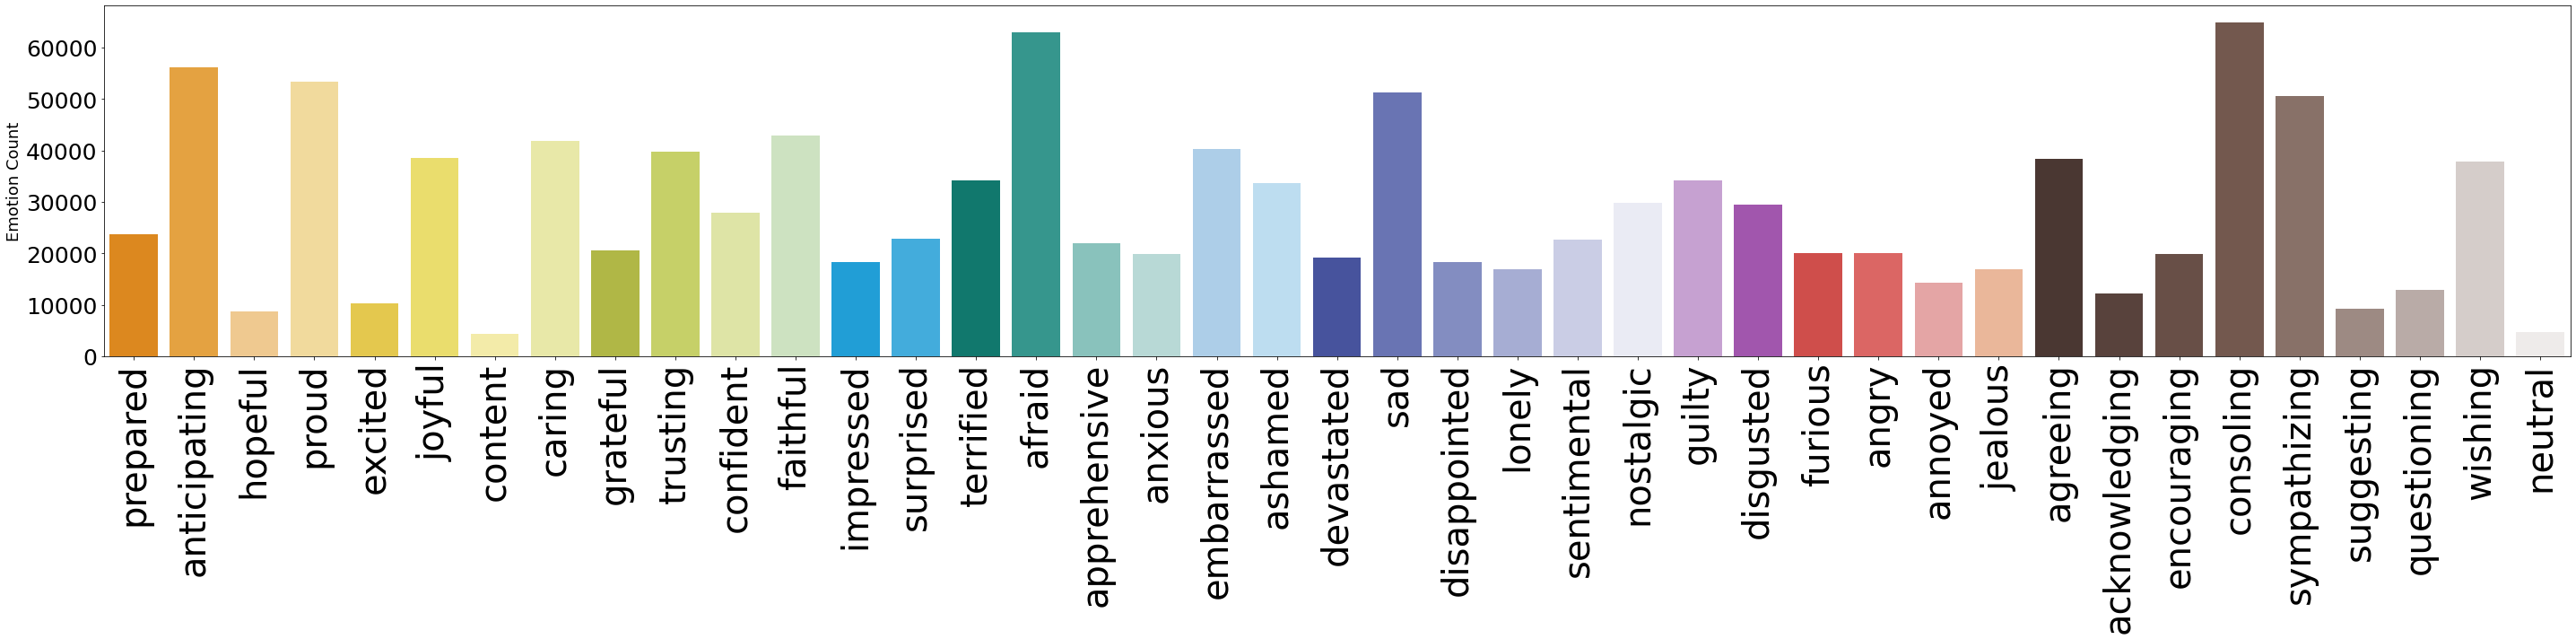

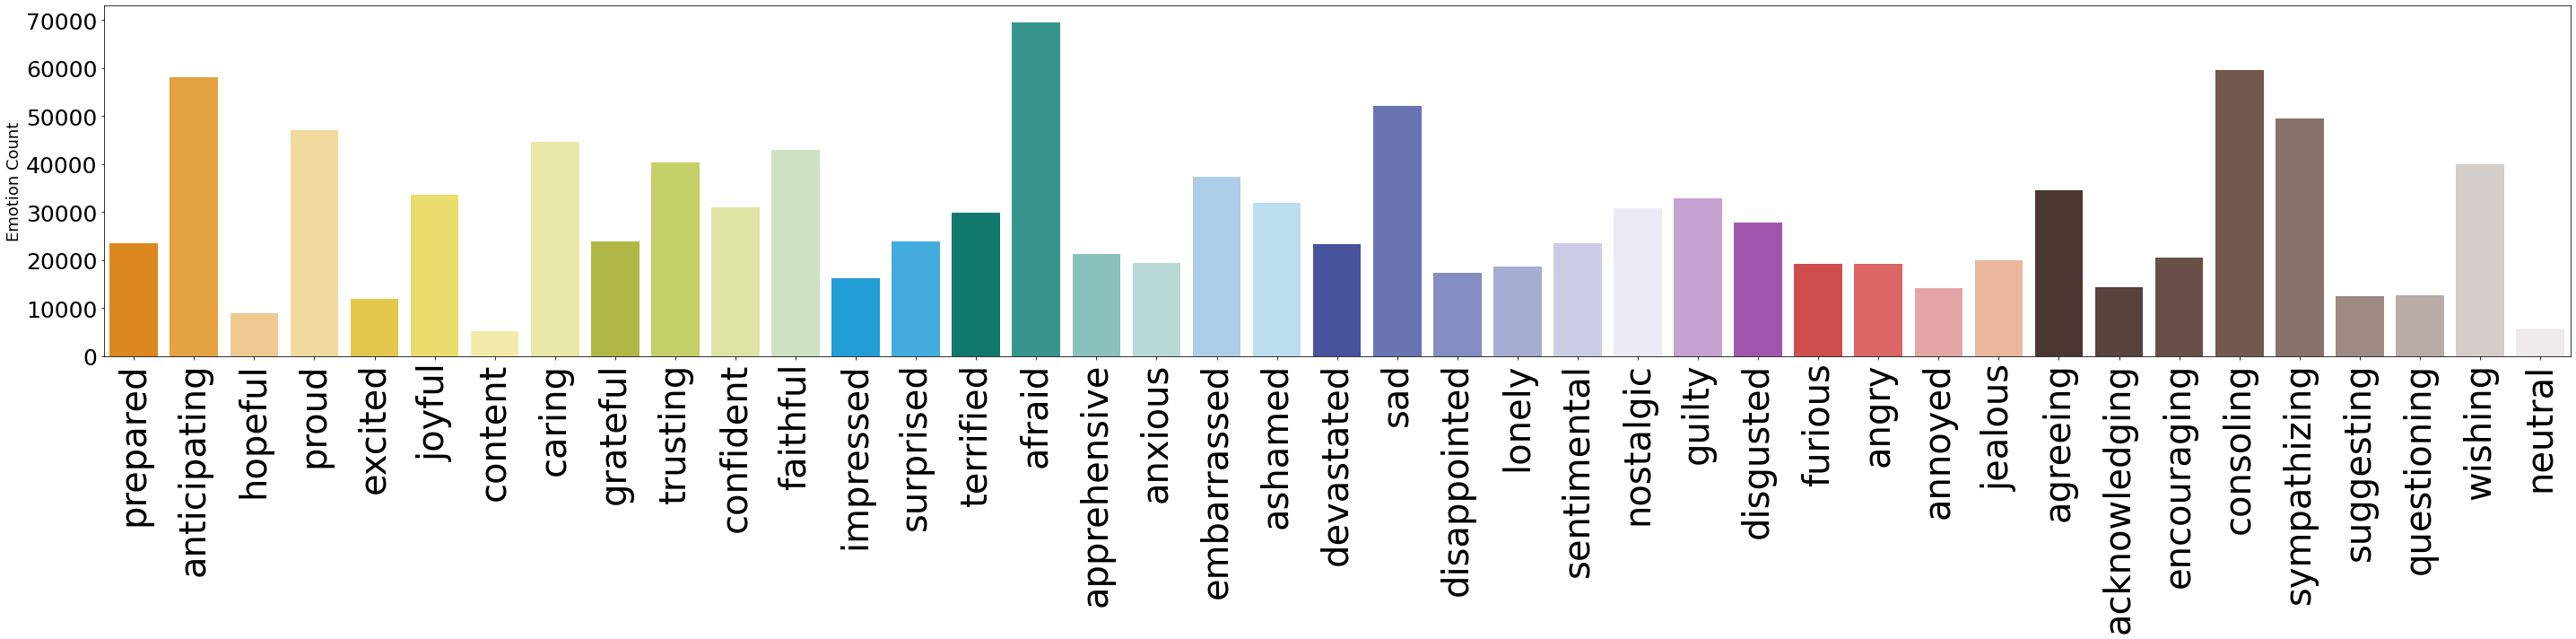

In [ ]:
# make plot for both speakers and listeners (including both dyadic and multiparty convs)
ED_color = {
            'prepared': '#fb8c00',
            'anticipating': '#ffa726',
            'hopeful': '#ffcc80',
            'proud': '#FFE18F',

            'excited': '#fdd835',
            'joyful': '#ffee58',
            'content': '#fff59d',
            'caring': '#F3F29D',

            'grateful': '#c0ca33',
            'trusting': '#d4e157',
            'confident': '#e6ee9c',
            'faithful': '#CCE7BC',

            'impressed': '#03a9f4',
            'surprised': '#29b6f6',

            'terrified': '#00897b',
            'afraid': '#26a69a',
            'apprehensive': '#80cbc4',
            'anxious': '#b2dfdb',

            'embarrassed': '#A3CFF2',
            'ashamed': '#B5DFF8',

            'devastated': '#3949ab',
            'sad': '#5c6bc0',
            'disappointed': '#7986cb',
            'lonely': '#9fa8da',
            'sentimental': '#c5cae9',
            'nostalgic': '#e8eaf6',
            'guilty': '#CA99D9',

            'disgusted': '#ab47bc',

            'furious': '#e53935',
            'angry': '#ef5350',
            'annoyed': '#ef9a9a',
            'jealous': '#F7B38D',

            'agreeing': '#4e342e',
            'acknowledging': '#5d4037',
            'encouraging': '#6d4c41',
            'consoling': '#795548',
            'sympathizing': '#8d6e63',
            'suggesting': '#a1887f',
            'questioning': '#bcaaa4',
            'wishing': '#d7ccc8',
            'neutral': '#efebe9'
            }

order = ['prepared', 'anticipating', 'hopeful', 'proud', 'excited', 'joyful', 'content', 'caring', 'grateful'
        , 'trusting', 'confident', 'faithful', 'impressed', 'surprised', 'terrified', 'afraid', 'apprehensive'
        , 'anxious', 'embarrassed', 'ashamed', 'devastated', 'sad', 'disappointed', 'lonely', 'sentimental'
        , 'nostalgic', 'guilty', 'disgusted', 'furious', 'angry', 'annoyed', 'jealous', 'agreeing', 'acknowledging'
        , 'encouraging', 'consoling', 'sympathizing', 'suggesting', 'questioning', 'wishing', 'neutral']

plt.figure(figsize = (40, 10))
ax = sns.barplot(data = dyadic_speaker_emotion_count, x = 'emotion', y = 'count', ci = None, palette = ED_color, order = order)
plt.xlabel('', fontsize=18)
plt.ylabel('Emotion Count', fontsize=18)
plt.xticks(fontsize = 40, rotation = 90)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.savefig('dyadic speaker emotion count.png')
plt.show()

plt.figure(figsize = (40, 10))
ax = sns.barplot(data = dyadic_listener_emotion_count, x = 'emotion', y = 'count', ci = None, palette = ED_color, order = order)
plt.xlabel('', fontsize=18)
plt.ylabel('Emotion Count', fontsize=18)
plt.xticks(fontsize = 40, rotation = 90)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.savefig('dyadic listener emotion count.png')
plt.show()

plt.figure(figsize = (40, 10))
ax = sns.barplot(data = multi_speaker_emotion_count, x = 'emotion', y = 'count', ci = None, palette = ED_color, order = order)
plt.xlabel('', fontsize=18)
plt.ylabel('Emotion Count', fontsize=18)
plt.xticks(fontsize = 40, rotation = 90)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.savefig('multiparty speaker emotion count.png')
plt.show()

plt.figure(figsize = (40, 10))
ax = sns.barplot(data = multi_listener_emotion_count, x = 'emotion', y = 'count', ci = None, palette = ED_color, order = order)
plt.xlabel('', fontsize=18)
plt.ylabel('Emotion Count', fontsize=18)
plt.xticks(fontsize = 40, rotation = 90)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.savefig('multiparty listener emotion count.png')
plt.show()

In [ ]:
dyadic_speaker_emotion_count_df = pd.DataFrame(dyadic_speaker_emotion_count)\
                                    .reset_index()\
                                    .rename(columns = {'index': 'emotion', 0: 'count'})

dyadic_listener_emotion_count_df = pd.DataFrame(dyadic_listener_emotion_count)\
                                    .reset_index()\
                                    .rename(columns = {'index': 'emotion', 0: 'count'})

In [ ]:
multi_speaker_emotion_count_df = pd.DataFrame(multi_speaker_emotion_count)\
                                    .reset_index()\
                                    .rename(columns = {'index': 'emotion', 0: 'count'})

multi_listener_emotion_count_df = pd.DataFrame(multi_listener_emotion_count)\
                                    .reset_index()\
                                    .rename(columns = {'index': 'emotion', 0: 'count'})

In [ ]:
dyadic_speaker_emotion_count

,emotion,count
0,acknowledging,24603.0
1,afraid,46944.0
2,agreeing,42118.0
3,angry,9493.0
4,annoyed,3689.0
5,anticipating,43594.0
6,anxious,39756.0
7,apprehensive,15670.0
8,ashamed,83464.0
9,caring,22649.0


### Useful references
1. [Install `Anaconda`](https://rjai.me/posts/google-colab-conda)

2. [Multi-Processing With Pandas](http://gouthamanbalaraman.com/blog/distributed-processing-pandas.html)

3. [Speed up your Pandas project](https://realpython.com/fast-flexible-pandas/#simple-looping-over-pandas-data), Real Python

4. [Generators explained](https://stackoverflow.com/a/231855/13360557), Stack overflow

5. [`joblib` parallel computing](https://stackoverflow.com/a/27027632/13360557), Stack overflow